In [1]:
import os, sys
sys.path.append(os.path.abspath("../"))
from utils.bootcampviztools import *
from utils.toolbox_ML import *

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

### REVISIÓN INICIAL DEL DATASET

In [ ]:
# Se carga el dataset de trabajo
df = pd.read_csv("../data/Datos_Reservas.csv")

# Se revisa la información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107563 entries, 0 to 107562
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   daily_price     107563 non-null  float64
 1   lead_time       107563 non-null  int64  
 2   adults          107563 non-null  int64  
 3   children        107563 non-null  int64  
 4   repeated_guest  107563 non-null  int64  
 5   total_book      107563 non-null  int64  
 6   pre_cancel      107563 non-null  int64  
 7   arr_date        107563 non-null  object 
 8   arr_week        107563 non-null  int64  
 9   week_nights     107563 non-null  int64  
 10  weekend_nights  107563 non-null  int64  
 11  meal_plan       107563 non-null  object 
 12  parking         107563 non-null  int64  
 13  special_req     107563 non-null  int64  
 14  canceled        107563 non-null  int64  
dtypes: float64(1), int64(12), object(2)
memory usage: 12.3+ MB


In [3]:
# Se revisa un conjunto de datos aleatorios del dataset
df.sample(10)

,daily_price,lead_time,adults,children,repeated_guest,total_book,pre_cancel,arr_date,arr_week,week_nights,weekend_nights,meal_plan,parking,special_req,canceled
47058,136.00,0,2,0,0,0,0,2016-09-13,37,1,0,BB,0,0,0
36641,115.00,47,2,0,0,0,0,2015-07-25,30,4,2,BB,0,1,0
65386,90.90,148,1,0,0,0,0,2016-08-26,34,2,1,BB,0,0,1
88893,72.25,159,2,0,0,0,0,2016-08-20,33,2,2,BB,0,0,0
60621,78.30,71,2,0,0,0,0,2016-02-17,7,3,0,BB,0,0,1
80817,118.00,3,2,0,0,0,0,2016-03-11,10,2,0,BB,0,2,0
101043,150.00,19,2,0,0,0,0,2017-05-06,18,1,1,SC,0,4,0
9024,70.00,270,1,0,0,0,0,2018-04-20,16,4,0,BB,0,0,0
86021,80.75,136,2,0,0,0,0,2016-06-28,26,5,2,SC,0,0,0
50293,215.25,54,2,2,0,0,0,2016-12-30,52,6,2,BB,1,0,0


In [4]:
# Se revisan las características de las variables numéricas (todas las variables del dataset, aunque se trate de variables categóricas)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
daily_price,107563.0,106.904933,51.967402,-6.38,75.0,99.0,133.0,5400.0
lead_time,107563.0,75.269265,80.849045,0.00,11.0,47.0,116.0,737.0
adults,107563.0,1.888940,0.607415,0.00,2.0,2.0,2.0,55.0
children,107563.0,0.144148,0.464924,0.00,0.0,0.0,0.0,10.0
repeated_guest,107563.0,0.038852,0.193242,0.00,0.0,0.0,0.0,1.0
total_book,107563.0,0.228740,2.034931,0.00,0.0,0.0,0.0,78.0
pre_cancel,107563.0,0.030633,0.383484,0.00,0.0,0.0,0.0,26.0
arr_week,107563.0,27.178463,13.700290,1.00,16.0,28.0,38.0,53.0
week_nights,107563.0,2.554522,1.956807,0.00,1.0,2.0,3.0,50.0
weekend_nights,107563.0,0.984920,1.004423,0.00,0.0,1.0,2.0,19.0


In [5]:
# Se muestra la ditribución de la variable que se empleará como target del problema
df.canceled.value_counts()

canceled
0    77086
1    30477
Name: count, dtype: int64

Mediante una observación superficial del dataset de trabajo al que se aplicarán los diferentes modelos de predicción se ha llegado a las siguientes conclusiones iniciales:
* La variable target está algo descompensada y habrá que decidir si se aplica alguna medida correctora para mitigar la diferencia de datos (oversampling, undersampling).
* Todas las variables son numéricas, lo que facilitará la aplicación de diferentes modelos, aunque aun deben distinguirse las variables numéricas naturales y las variables categóricas que cuentan con números como etiquetas.
* En alguna de las variables categóricas no binarias es probable que se aplique alguna transformación para convertirlas en binarias según la distribución de valores que tengan.

A continuación se describen las variables contenidas en el dataset.


##### **DESCRIPCIÓN DE LAS VARIABLES**

---

<div style="background-color: AliceBlue;">

| Variable | Tipo | Descripción |
|:---------|:----:|:------------|
| daily_price | float64 | Precio diario medio de la reserva efectuada, en euros.|
| lead_time | int64 | Días transcurridos entre la fecha de reserva y el día previsto de llegada.| 
| adults | int64 |---|
| children | int64 |---| 
| repeated_guest | int64 |---| 
| total_book | int64 |---| 
| pre_cancel | int64 |---| 
| arr_date | datetime64 |---|
| arr_week | int64 |---|
| week_nights | int64 |---|
| weekend_nights | int64 |---|
| meal_plan | object |---|
| parking | int64 |---|
| special_req | int64 |---|
| canceled | int64 |---|

</div>

---


About columns

    ID : unique identifier of each booking
    n_adults : Number of adults
    n_children : Number of Children
    weekend_nights : Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
    week_nights : Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
    meal_plan : Type of meal plan booked by the customer:
    car_parking_space : Does the customer require a car parking space? (0 - No, 1- Yes)
    room_type : Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
    lead_time : Number of days between the date of booking and the arrival date
    year : Year of arrival date
    month : Month of arrival date
    date : Date of the month
    market_segment : Market segment designation.
    repeated_guest : Is the customer a repeated guest? (0 - No, 1- Yes)
    previous_cancellations : Number of previous bookings that were canceled by the customer prior to the current booking
    previous_bookings_not_canceled : Number of previous bookings not canceled by the customer prior to the current booking
    avg_room_price : Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
    special_requests : Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
    status : Flag indicating if the booking was canceled or not.


### DIVISIÓN DE LOS DATOS EN CONJUNTOS DE TRAIN Y TEST

In [6]:
# Se separa los conjuntos de datos de train y test
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

# Se identifica el target
target = "canceled"

### VISUALIZACIÓN DE LAS VARIABLES

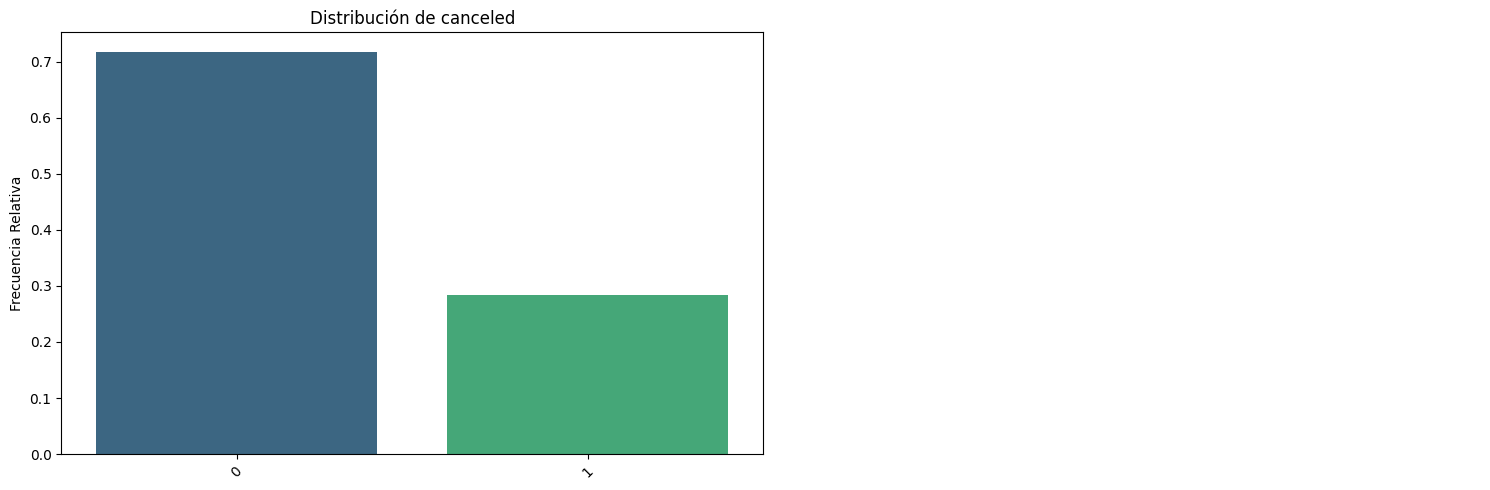

In [7]:
# Se imprime la distribución de frecuencia relativa de la variable 'target' (0 = No cancelada, 1 = Cancelada)
pinta_distribucion_categoricas(train_set, [target], relativa = True)

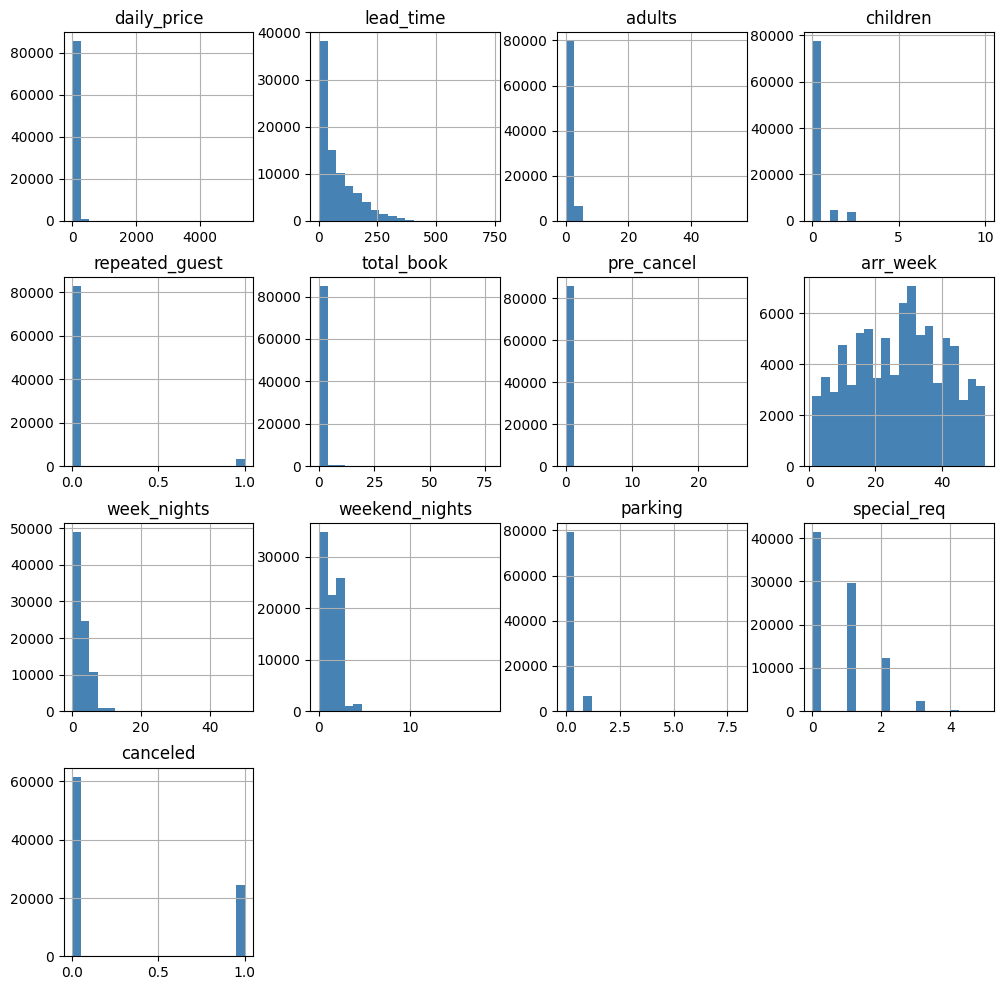

In [8]:
# Se revisa visualmente la distribución de todas las variables
train_set.hist(bins = 20, color = "steelblue", figsize = (12,12));

##### DAILY_PRICE

daily_price
0.00      1742
65.00     1263
75.00     1197
85.00      868
95.00      839
          ... 
333.67       1
199.26       1
240.70       1
143.73       1
123.96       1
Name: count, Length: 8101, dtype: int64


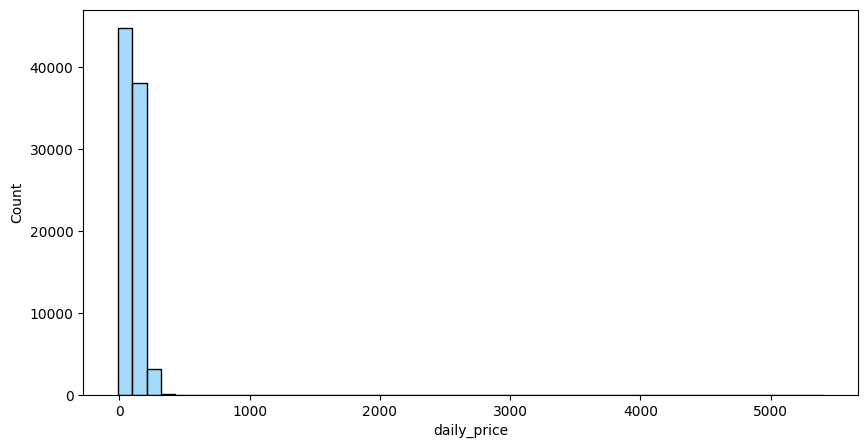

In [9]:
print(train_set.daily_price.value_counts())
fig, axs = plt.subplots(1,1, figsize = (10,5))
sns.histplot(train_set.daily_price, bins = 50, color = "lightskyblue");

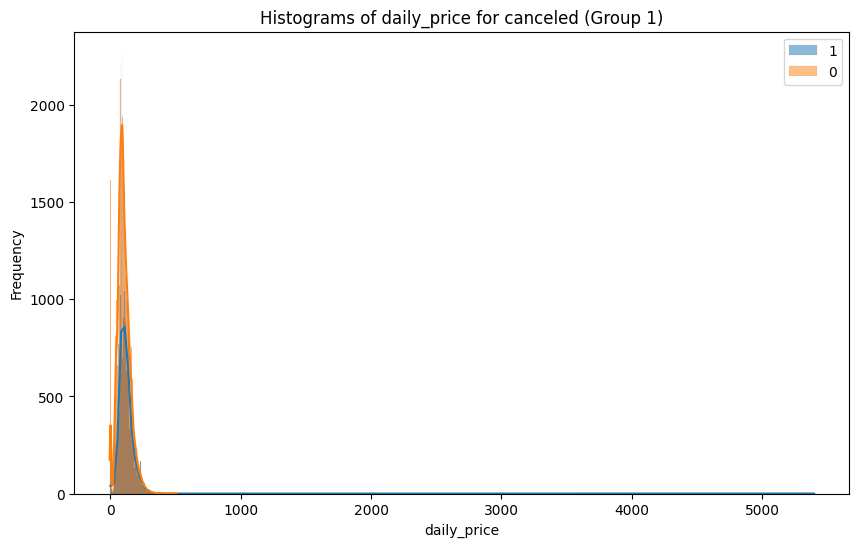

In [10]:
# Distribución de la variable en relación al 'target' (0 = No cancelada, 1 = Cancelada)
plot_grouped_histograms(train_set,"canceled", "daily_price",2);

(2,)


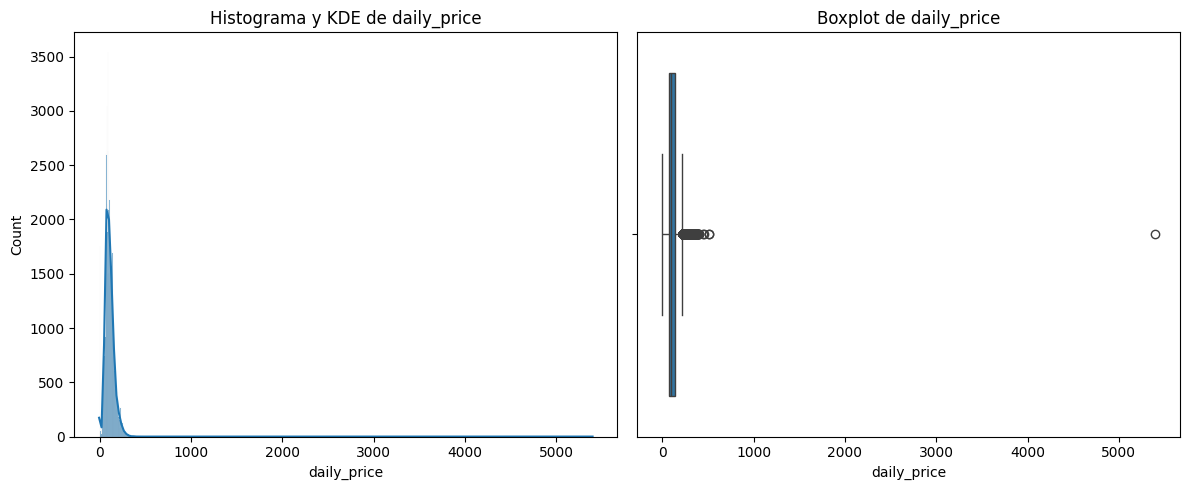

In [11]:
plot_combined_graphs(train_set,["daily_price"]);

In [12]:
train_set.loc[train_set.daily_price > 2000]

,daily_price,lead_time,adults,children,repeated_guest,total_book,pre_cancel,arr_date,arr_week,week_nights,weekend_nights,meal_plan,parking,special_req,canceled
61451,5400.0,35,2,0,0,0,0,2016-03-25,12,1,0,BB,0,0,1


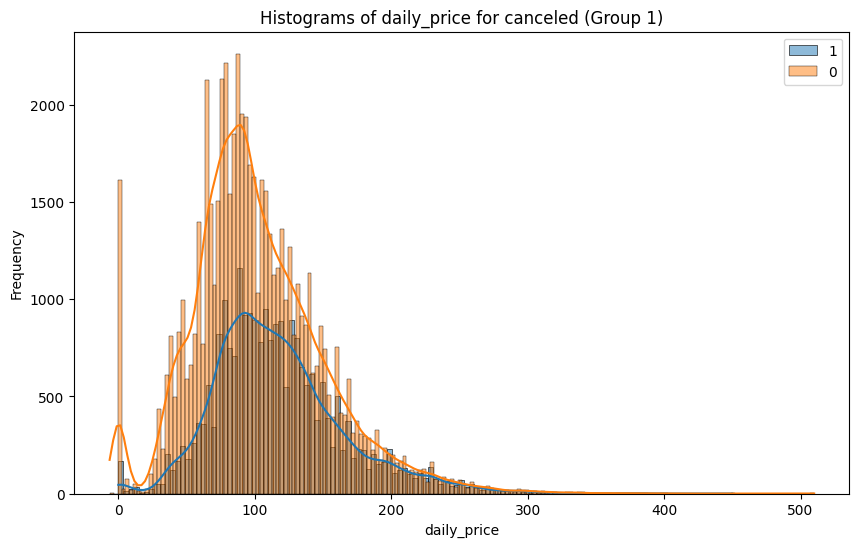

In [13]:
# Distribución de la variable en relación al 'target' (0 = No cancelada, 1 = Cancelada), sin tener en cuenta los outliers para aproximar la vista
plot_grouped_histograms(train_set[train_set.daily_price <= 2000],"canceled", "daily_price",2);

¿Por qué hay registros con valor cero en el importe medio diario?  
¿Pueden ser promociones?

In [14]:
train_set.loc[train_set.daily_price <= 0]

,daily_price,lead_time,adults,children,repeated_guest,total_book,pre_cancel,arr_date,arr_week,week_nights,weekend_nights,meal_plan,parking,special_req,canceled
22221,0.0,0,2,0,0,0,0,2017-08-13,32,0,0,BB,0,2,0
75588,0.0,1,1,0,0,0,0,2015-08-12,33,2,0,BB,0,0,0
24893,0.0,0,1,0,1,21,4,2018-06-07,23,1,0,BB,0,1,0
24314,0.0,0,2,0,0,0,0,2017-11-05,44,1,0,BB,0,2,0
75239,0.0,153,1,0,0,1,1,2015-08-03,32,2,1,BB,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18711,0.0,9,2,0,0,0,0,2018-11-11,45,2,0,BB,1,3,0
36212,0.0,2,1,0,1,2,0,2016-12-14,50,0,0,BB,0,0,0
49811,0.0,0,1,0,1,0,0,2016-12-19,51,0,0,BB,0,1,0
80356,0.0,116,1,0,0,0,0,2016-02-28,8,2,2,BB,0,0,0


En los registros sin coste se observa una mayor diferencia de frecuencias con respecto a las cancelaciones, a favor de las reservas no canceladas. 
El dibujo del KDE en las opciones sigue un patrón equivalente, por lo que no parece que el coste diario tenga mucha influencia en el target.  
  
Se decide eliminar los registros con valor cero por la siguiente razón:  
* El problema de negocio es identificar las características de las reservas potencialmente canceladas, para crear un modelo de predicción que alerte sobre ellas. Que la consecución de la reserva suponga un ingreso o no para el alojamiento no altera la realidad de la pérdida que supone reservar un espacio al que no se le dará uso posterior en caso de cancelación, por lo que en caso de que el dato tenga relación con el 'target', en principio ésta se daría independientemente de que se trate de una oferta o de una reserva convencional. 
Sin embargo, se observa una mayor concentración de reservas no canceladas cuando se trata de una reserva sin coste, por lo que su eliminación conducirá a un modelo más preciso en el resto (la mayoría) de casos, además de suponer un menor desbalanceo respecto a las variables 'adult' y 'target'. 
  
Aunque aparentemente no parece relevante en los motivos de cancelación de las reservas, se decide mantener la variable aplicando una transformación logística para facilitar el posterior cálculo del modelo.  
Además, a partir de la visualización de estos registros con 'daily_price' igual o inferior a cero surge otra pregunta que se tratará más adelante.
* ¿Por qué hay registros con cero adultos y cero niños?  
  

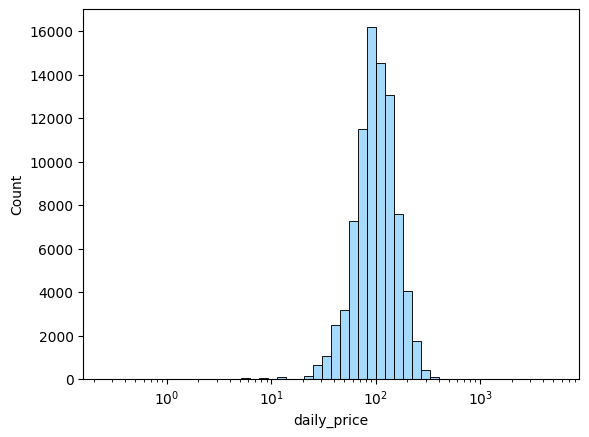

In [15]:
# Gráfico de la variable con la transformación logística
sns.histplot(train_set.daily_price, bins = 50, color = "lightskyblue", log_scale = 10);

In [16]:
#---------------------------- CAMBIO 1-----------------------------------------
# ELIMINACIÓN DE REGISTROS DE PROMOCIONES, DEVOLUCIONES Y POSIBLES ERRORES
# TRANSFORMACIÓN LOGÍSTICA A LA COLUMNA 'daily_price'

# Train
#X_train.loc[X_train["daily_price"] <= 0, "daily_price"] = 1
train_set = train_set.drop(train_set[train_set["daily_price"] <= 0].index, axis = 0)
train_set = train_set.drop(train_set[train_set["daily_price"] > 2000].index, axis = 0)
train_set["daily_price"] = np.log10(train_set["daily_price"])

# Test
#X_test.loc[X_test["daily_price"] <= 0, "daily_price"] = 1
test_set = test_set.drop(test_set[test_set["daily_price"] <= 0].index, axis = 0)
test_set = test_set.drop(test_set[test_set["daily_price"] > 2000].index, axis = 0)
test_set["daily_price"] = np.log10(test_set["daily_price"])

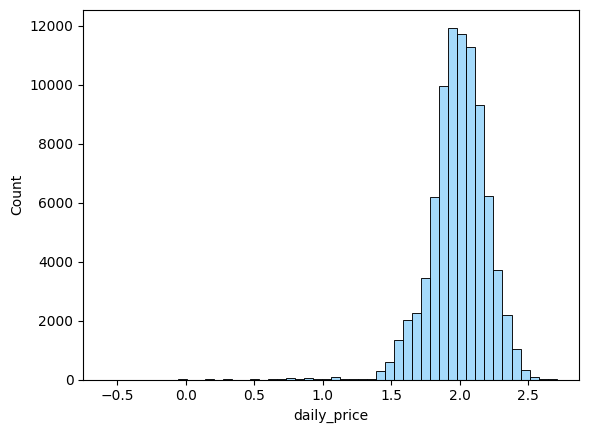

In [17]:
sns.histplot(train_set.daily_price, bins = 50, color = "lightskyblue");

##### LEAD_TIME

lead_time
0      4899
1      3008
2      1854
3      1658
4      1566
       ... 
626       1
371       1
538       1
411       1
389       1
Name: count, Length: 474, dtype: int64


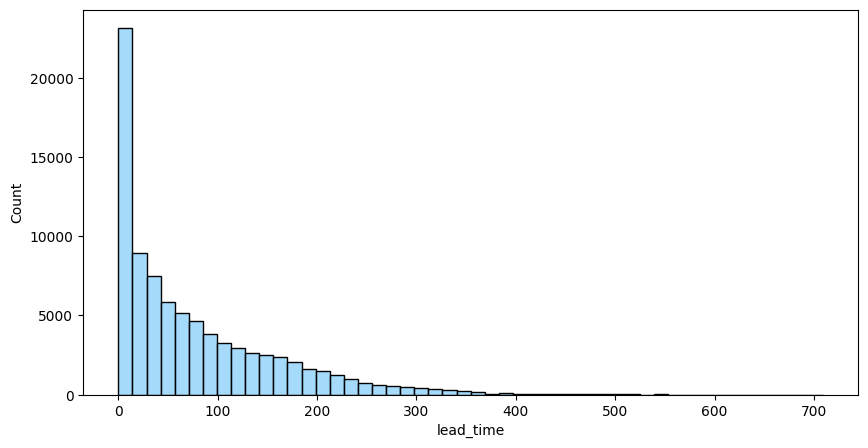

In [18]:
print(train_set.lead_time.value_counts())
fig, axs = plt.subplots(1,1, figsize = (10,5))
sns.histplot(train_set.lead_time, bins = 50, color = "lightskyblue");

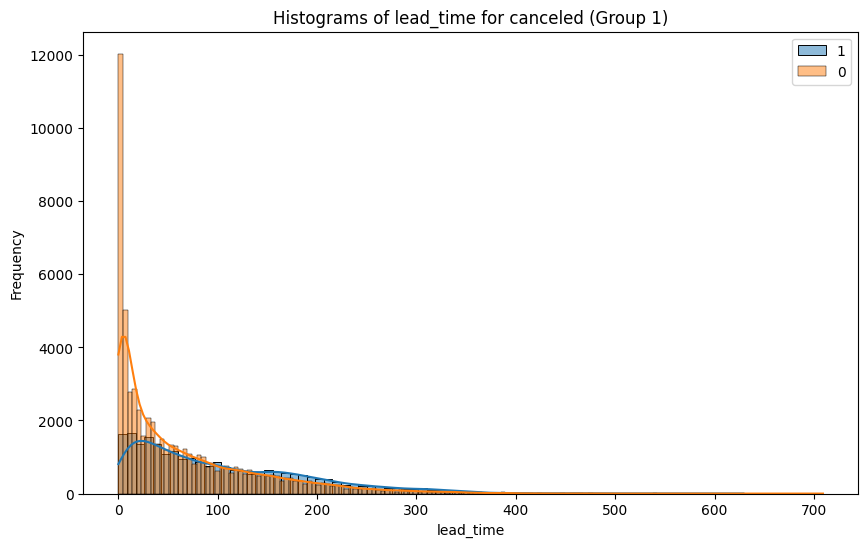

In [19]:
# Distribución de la variable en relación al 'target' (0 = No cancelada, 1 = Cancelada)
plot_grouped_histograms(train_set,"canceled", "lead_time",2);

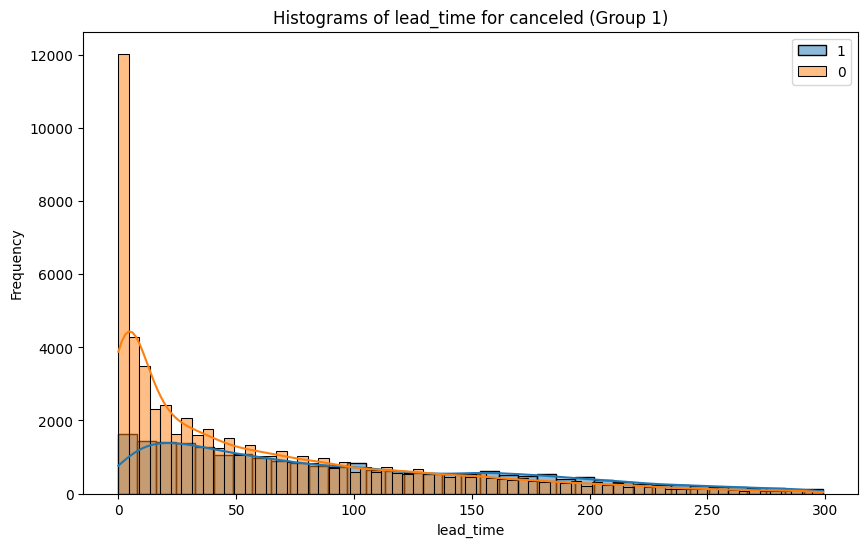

In [20]:
# Aproximamos de nuevo la vista evitando los outliers
plot_grouped_histograms(train_set[train_set.lead_time < 300],"canceled", "lead_time",2);

(2,)


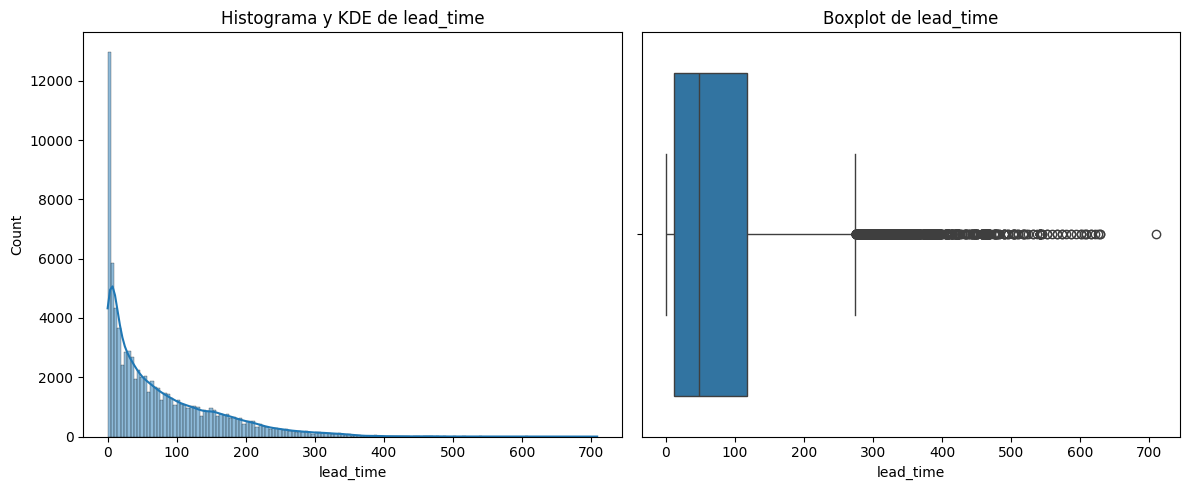

In [21]:
plot_combined_graphs(train_set,["lead_time"]);

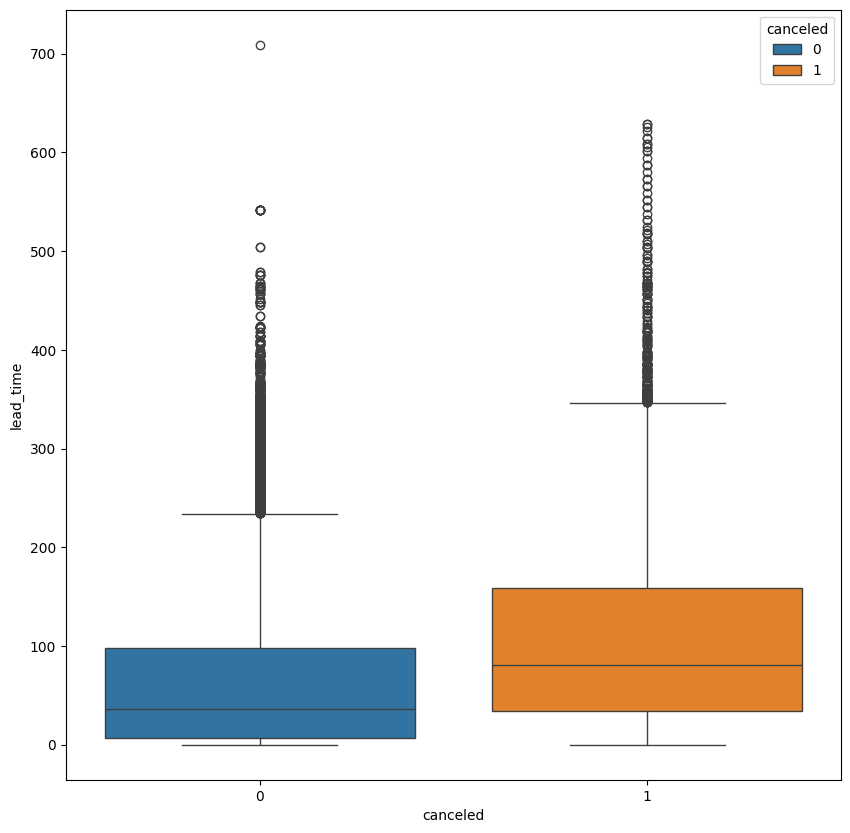

In [22]:
plt.figure(figsize=(10,10)) 
sns.boxplot(x = "canceled", y = "lead_time", hue = "canceled", data = train_set);

La variable 'lead_time' tiene una distribución lógica, con una relación directa entre el número de registros y el incremento en los días.  
Se puede distinguir además que está muy relacionada con el 'target'; las frecuencias de cancelación se invierten en diferentes tramos.  
  
Se eliminarán los registros con 'lead_time' igual a cero, por consistencia en los datos, porque se entiende que una reserva efectuada el mismo día de la llegada no se cancelará salvo que se trate de un error de inserción de datos.  
Se mantiene la variable, aunque se aplicará una transformación logística en sus valores.

In [23]:
#---------------------------- CAMBIO 2-----------------------------------------
# ELIMINACIÓN DE VALORES INCONSISTENTES Y TRANSFORMACIÓN LOGÍSTICA A LA COLUMNA 'lead_time'

# Train
train_set = train_set.drop(train_set[train_set["lead_time"] <= 0].index, axis = 0)
train_set["lead_time"] = np.log10(train_set["lead_time"])

# Test
test_set = test_set.drop(test_set[test_set["lead_time"] <= 0].index, axis = 0)
test_set["lead_time"] = np.log10(test_set["lead_time"])

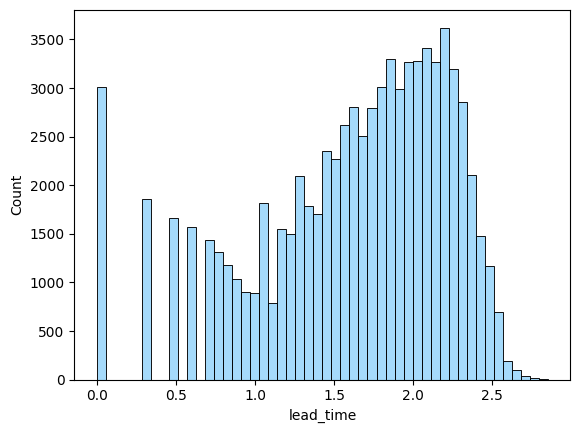

In [24]:
sns.histplot(train_set.lead_time, bins = 50, color = "lightskyblue");

##### ADULTS

adults
2    59918
1    12958
3     6196
0      281
4       54
Name: count, dtype: int64


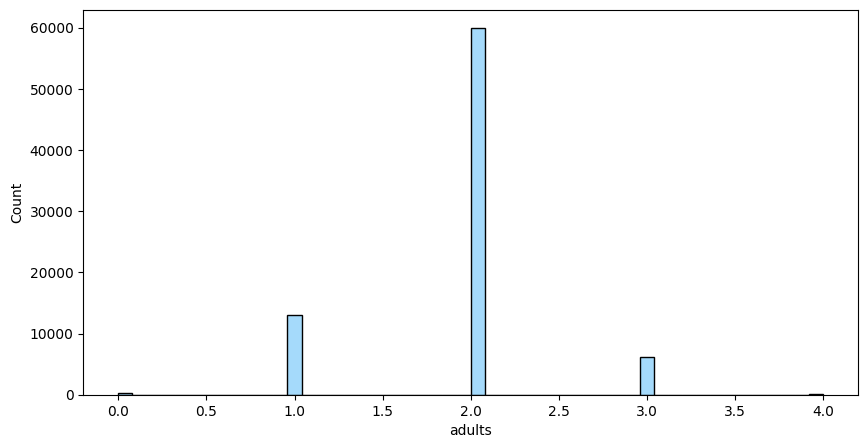

In [25]:
print(train_set.adults.value_counts())
fig, axs = plt.subplots(1,1, figsize = (10,5))
sns.histplot(train_set.adults, bins = 50, color = "lightskyblue");

Los registros con valor cero se mantienen, porque pueden tratarse de reservas de varias habitaciones para una misma familia con dos adultos y varios hijos.  
No parece una variable muy determinante en la predicción de cancelación, puesto que las frecuencias se mantienen más o menos en los mismos rangos.  
Sí se eliminarán los registros con valor cero coincidente tanto en 'adults' como en 'children', por tratarse de datos inconsistentes.

In [26]:
train_set.loc[(train_set.adults == 0)&(train_set.children == 0)]

,daily_price,lead_time,adults,children,repeated_guest,total_book,pre_cancel,arr_date,arr_week,week_nights,weekend_nights,meal_plan,parking,special_req,canceled
101217,2.301030,1.518514,0,0,0,0,0,2017-05-09,19,1,0,SC,0,0,0
62631,1.706462,2.086360,0,0,0,0,0,2016-05-05,18,4,2,SC,0,0,0
93493,0.921166,2.146128,0,0,0,0,0,2016-09-22,38,41,16,SC,0,2,0
95425,0.110590,2.247973,0,0,0,0,0,2016-12-30,52,5,2,BB,0,2,0
95072,1.319730,2.406540,0,0,0,0,0,2016-12-27,52,3,0,BB,0,0,0
104022,2.003461,2.029384,0,0,0,0,0,2017-06-27,26,3,0,BB,0,0,0
93643,1.988559,1.568202,0,0,0,0,0,2016-11-17,46,3,1,SC,1,1,0
81318,0.528917,0.954243,0,0,0,0,0,2016-03-16,11,6,2,SC,1,0,0
97347,1.554004,0.000000,0,0,0,0,0,2017-02-12,6,10,5,SC,0,0,0
93161,2.218483,1.755875,0,0,0,0,0,2016-11-09,45,2,0,SC,0,2,0


In [27]:
#---------------------------- CAMBIO 3-----------------------------------------
# ELIMINACIÓN DE REGISTROS CON VALOR 0 COINCIDENTES EN LAS COLUMNAS 'adults' Y 'children'

# Train
train_set = train_set.drop(train_set[(train_set["adults"] == 0)&(train_set["children"] == 0)].index, axis = 0)

# Test
test_set = test_set.drop(test_set[(test_set["adults"] == 0)&(test_set["children"] == 0)].index, axis = 0)

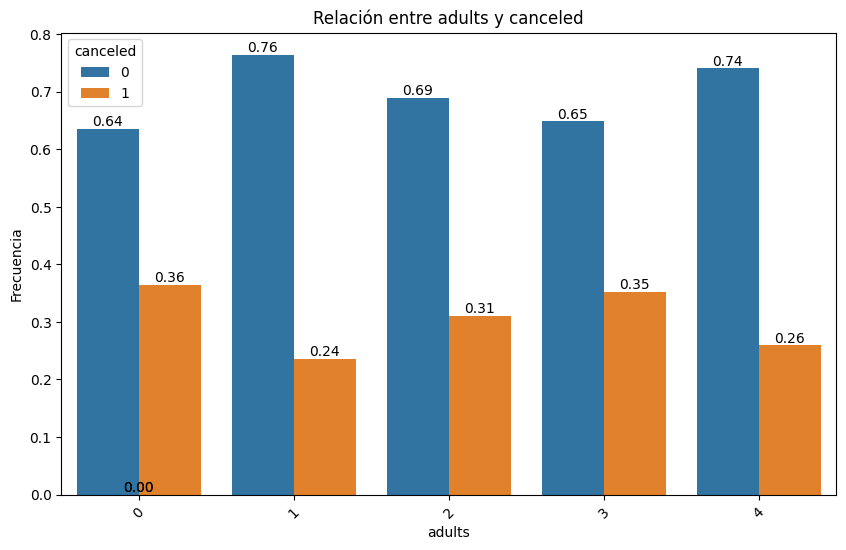

In [28]:
plot_categorical_relationship_fin(train_set, "adults","canceled", relative_freq = True, show_values = True)

##### CHILDREN

children
0     71211
1      4582
2      3526
3        61
10        2
9         2
Name: count, dtype: int64


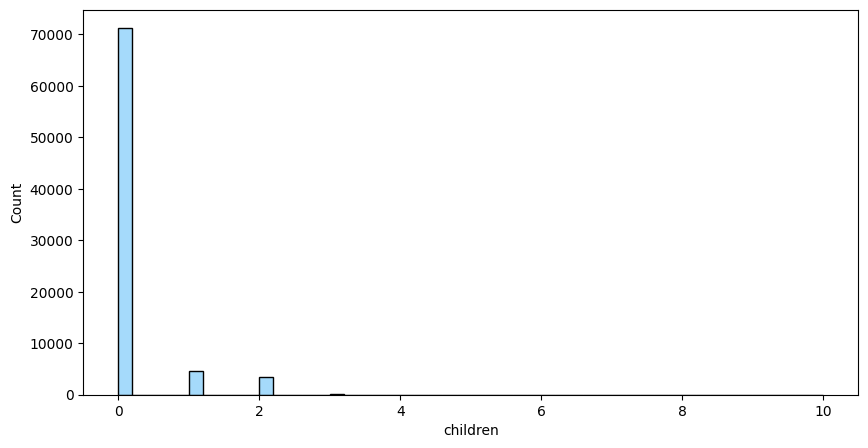

In [29]:
print(train_set.children.value_counts())
fig, axs = plt.subplots(1,1, figsize = (10,5))
sns.histplot(train_set.children, bins = 50, color = "lightskyblue");

La distribución es categórica, aunque se agruparán los valores en dos etiquetas, con hijos (1) y sin hijos (0), para transformarla en una variable binaria.  
Se mantiene la variable transformada, aunque no parece que haya mucha influencia en las cancelaciones respecto a si la reserva incluye alojamiento para niños o no.

In [30]:
#---------------------------- CAMBIO 4-----------------------------------------
# TRANSFORMACIÓN DE 'children' A CATEGÓRICA BINARIA

# Train
train_set.loc[train_set["children"] > 0, "children"] = 1

# Test
test_set.loc[test_set["children"] > 0, "children"] = 1

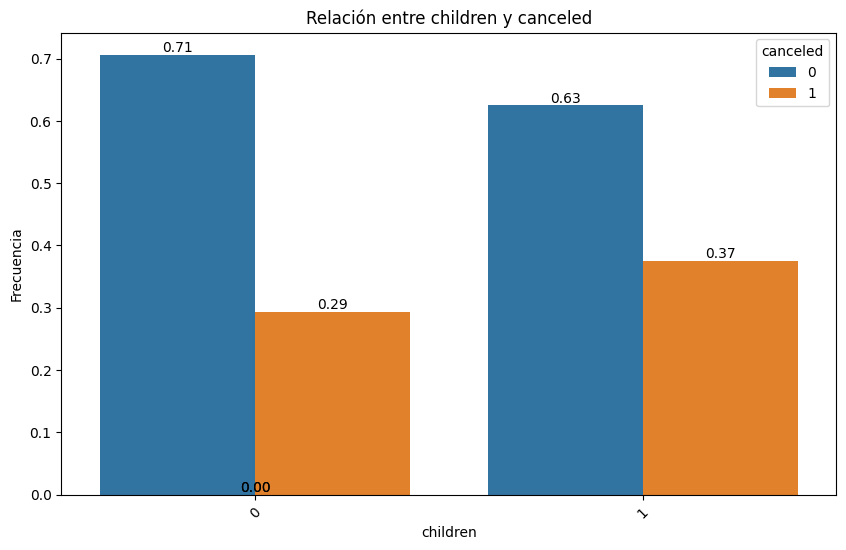

In [31]:
plot_categorical_relationship_fin(train_set, "children","canceled", relative_freq = True, show_values = True)

##### REPEATED_GUEST

repeated_guest
0    77224
1     2160
Name: count, dtype: int64


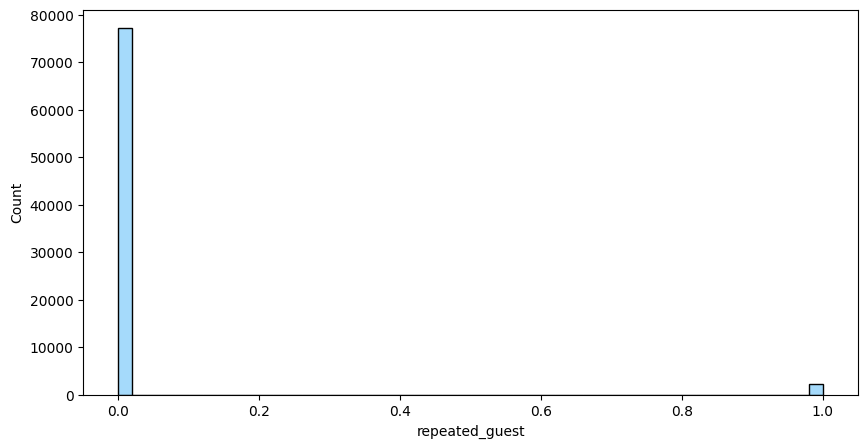

In [32]:
print(train_set.repeated_guest.value_counts())
fig, axs = plt.subplots(1,1, figsize = (10,5))
sns.histplot(train_set.repeated_guest, bins = 50, color = "lightskyblue");

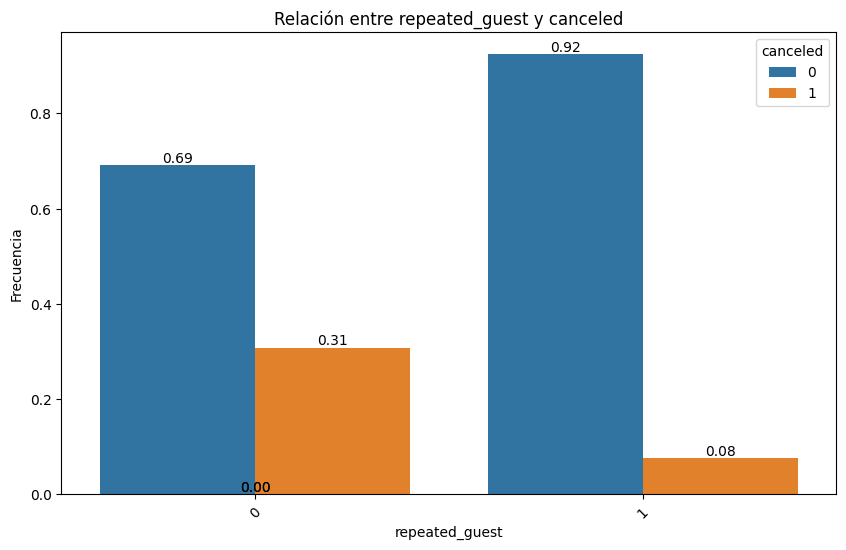

In [33]:
plot_categorical_relationship_fin(train_set, "repeated_guest","canceled", relative_freq = True, show_values = True)

Se trata de una variable binaria sin valores extraños. Se observa que si el cliente ya había estado en el establecimiento la probabilidad de cancelación de la reserva es mucho menor.  
Parace que será una variable importante en el modelo de predicción.  
Se mantiene sin cambios.

##### TOTAL_BOOK

total_book
0     76136
1      1668
2       413
3       235
4       168
      ...  
71        1
65        1
72        1
61        1
50        1
Name: count, Length: 70, dtype: int64


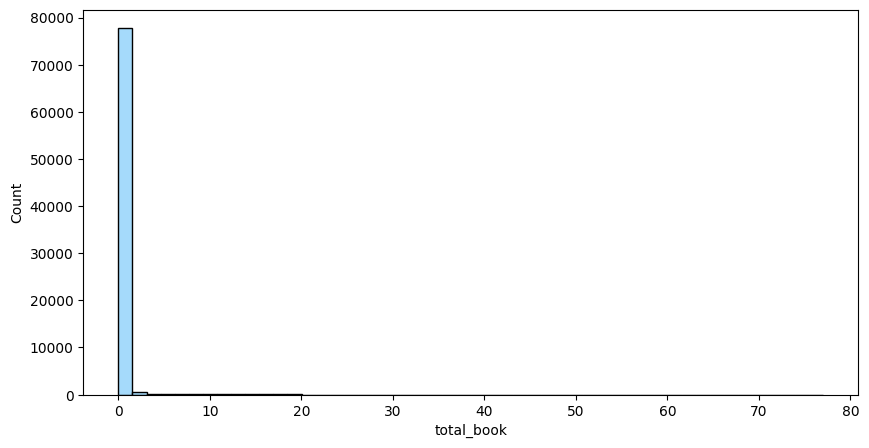

In [34]:
print(train_set.total_book.value_counts())
fig, axs = plt.subplots(1,1, figsize = (10,5))
sns.histplot(train_set.total_book, bins = 50, color = "lightskyblue");

Parece una feature redundante con la variable anterior, que especificaba si el cliente había estado anteriormente.  
Como en otros casos anteriores, se transformará la variable en una binaria con os valores 0 (no hay reservas previas) y 1 (sí hay reservas previas).  
No parece una variable muy relevante, pero se mantiene en cualquier caso.

In [35]:
#---------------------------- CAMBIO 5-----------------------------------------
# TRANSFORMACIÓN DE 'total_book' A CATEGÓRICA BINARIA

# Train
train_set.loc[train_set["total_book"] > 0, "total_book"] = 1

# Test
test_set.loc[test_set["total_book"] > 0, "total_book"] = 1

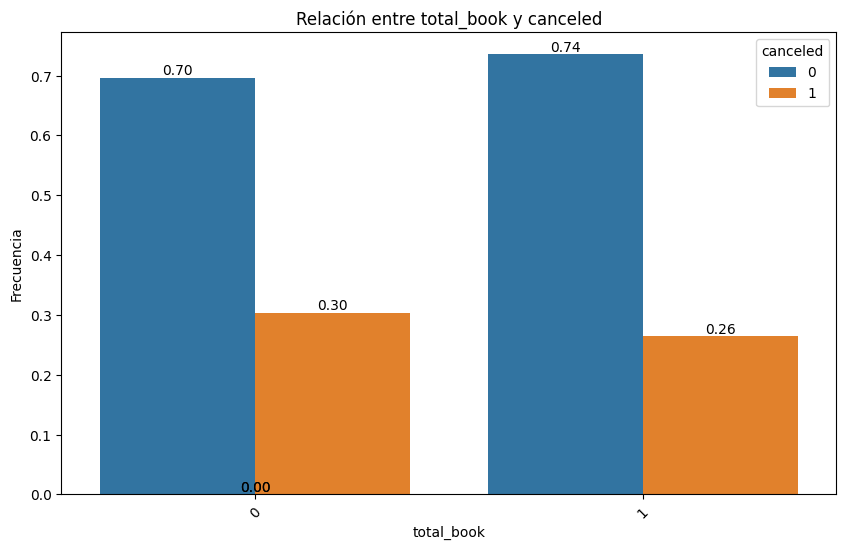

In [36]:
plot_categorical_relationship_fin(train_set, "total_book","canceled", relative_freq = True, show_values = True)

##### PRE_CANCEL

pre_cancel
0     78080
1      1080
2        70
3        64
11       36
5        20
4        14
6        12
24        2
13        2
26        1
21        1
25        1
19        1
Name: count, dtype: int64


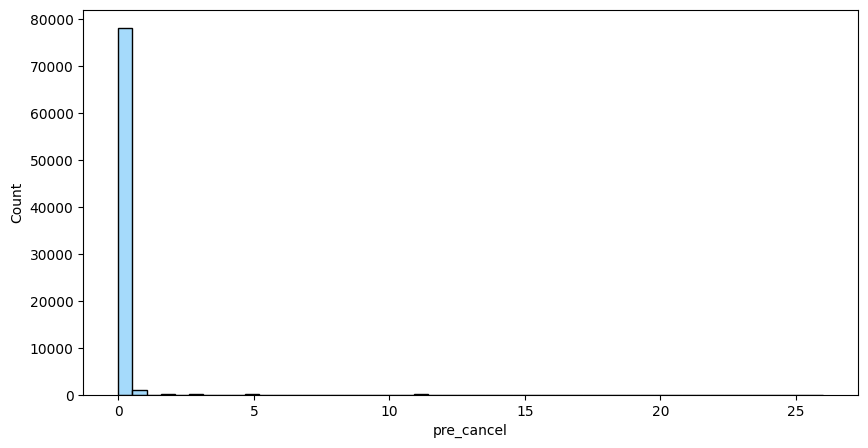

In [37]:
print(train_set.pre_cancel.value_counts())
fig, axs = plt.subplots(1,1, figsize = (10,5))
sns.histplot(train_set.pre_cancel, bins = 50, color = "lightskyblue");

Se transforma en categórica binaria y se mantiene la variable.  
En este caso se observa como resulta determinante respecto a la variable 'target'; en los casos en que se ha cancelado previamente el porce3ntaje de cancelaciones es mayor que el de reservas que se mantienen.  
¿Es posible que se deba a cancelaciones derivadas de reservas hechas por agencias? No puede saberse porque la columna 'ms_type' no contenía datos limpios para hacer una valoración.

In [38]:
#---------------------------- CAMBIO 6-----------------------------------------
# TRANSFORMACIÓN DE 'pre_cancel' Y 'pre_not_cancel' A CATEGÓRICA BINARIA

# Train
train_set.loc[train_set["pre_cancel"] > 0, "pre_cancel"] = 1
#train_set.loc[train_set["pre_not_cancel"] > 0, "pre_cancel"] = 1 # Solo en caso de full dataset

# Test
test_set.loc[test_set["pre_cancel"] > 0, "pre_cancel"] = 1
#test_set.loc[test_set["pre_not_cancel"] > 0, "pre_cancel"] = 1 # Solo en caso de full dataset

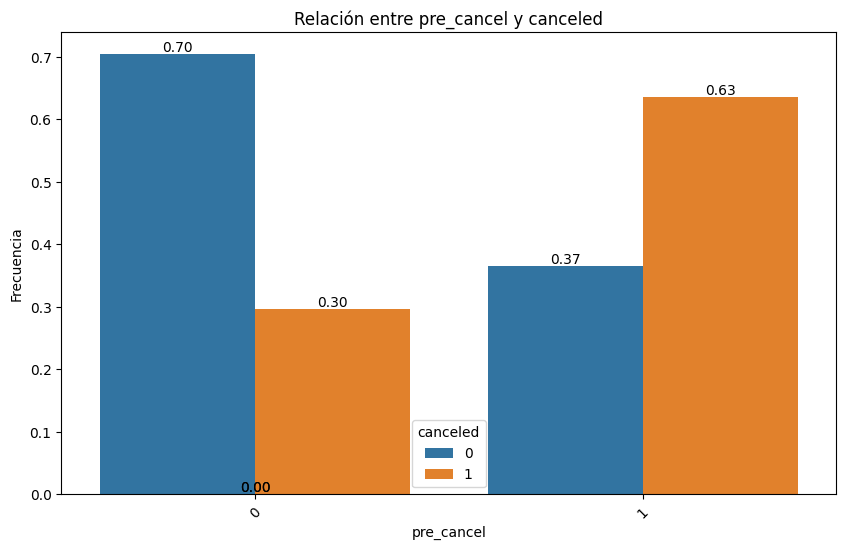

In [39]:
plot_categorical_relationship_fin(train_set, "pre_cancel","canceled", relative_freq = True, show_values = True)

##### ARR_DATE

arr_date
2017-04-29    175
2017-07-15    171
2016-06-26    164
2017-05-25    162
2017-08-07    162
             ... 
2018-01-11      4
2017-12-22      4
2017-11-24      4
2017-12-12      1
2017-12-07      1
Name: count, Length: 1280, dtype: int64


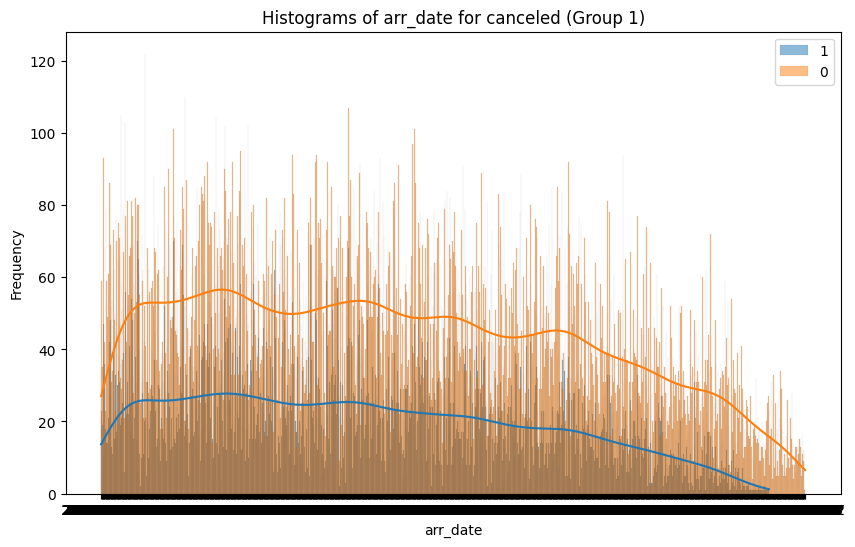

In [40]:
print(train_set.arr_date.value_counts())
plot_grouped_histograms(train_set,"canceled", "arr_date",2);

Se observan algunos picos de actividad en fechas determinadas, pero las curvas son equivalentes.  
Se elimina la variable porque la información que puede ofrecer se encuentra en la siguiente variable agrupadas por semanas.

In [41]:
#---------------------------- CAMBIO 7-----------------------------------------
# ELIMINACIÓN DE 'arr_date'

# Train
train_set.drop(columns = ["arr_date"], inplace = True)

# Test
test_set.drop(columns = ["arr_date"], inplace = True)

##### ARR_WEEK

arr_week
33    2533
32    2363
34    2282
31    2236
28    2164
30    2044
27    2005
29    1957
35    1934
26    1864
15    1785
17    1757
18    1692
43    1689
20    1671
22    1632
40    1621
38    1614
19    1605
21    1599
14    1599
37    1583
24    1582
36    1579
52    1562
42    1548
11    1548
23    1539
16    1534
25    1505
12    1480
13    1458
10    1421
44    1418
39    1404
41    1393
9     1369
8     1347
49    1284
46    1248
7     1247
45    1229
6     1221
47    1078
5     1022
48     974
51     931
1      814
4      805
3      755
50     734
2      722
53     404
Name: count, dtype: int64


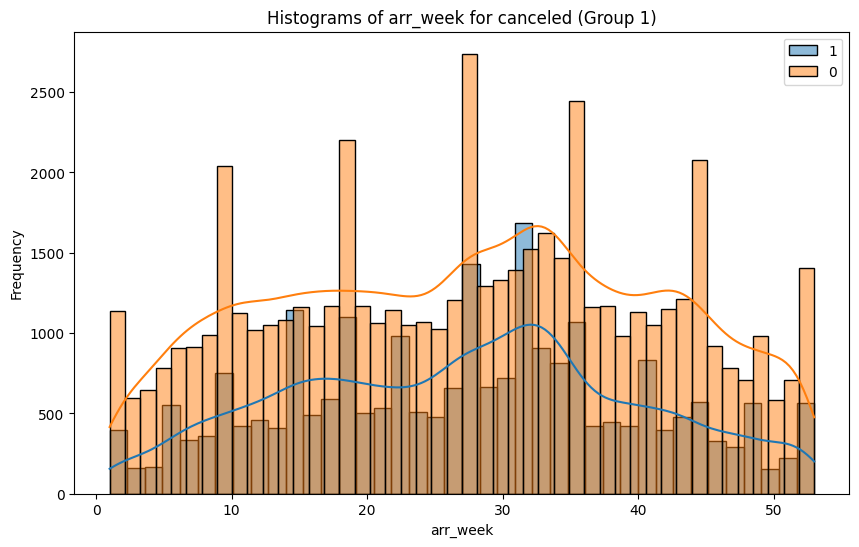

In [42]:
print(train_set.arr_week.value_counts())
plot_grouped_histograms(train_set,"canceled", "arr_week",2);

En la gráfica se puede observar cómo hay determinadas semanas en que es mayoritaria la cancelación a pesar de la diferencia de registros entre ambos casos.  
Esta variable se considera relevante y se mantienen los datos.

##### WEEK_NIGHTS

week_nights
2     19946
1     18699
3     16205
5      8467
4      7795
0      4505
6      1169
7       812
10      782
8       523
9       189
15       63
11       57
12       32
20       28
13       22
14       22
19       16
21       10
16        9
25        6
18        6
22        6
17        6
30        3
40        2
42        1
24        1
50        1
26        1
Name: count, dtype: int64


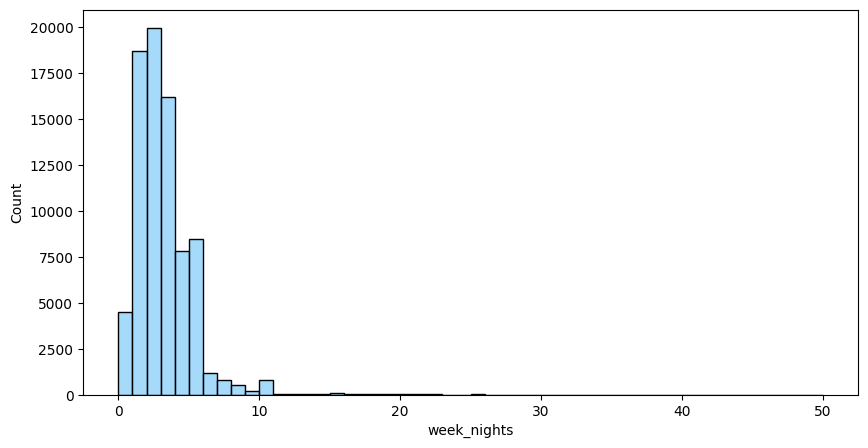

In [43]:
print(train_set.week_nights.value_counts())
fig, axs = plt.subplots(1,1, figsize = (10,5))
sns.histplot(train_set.week_nights, bins = 50, color = "lightskyblue");

Se eliminan (si los hubiera) los resultados en los que tanto 'week_nights' como 'weekend_nights' son igual a cero, por inconsistencia en los datos.  
Se crea una etiqueta para valores por encima de 5, de forma que las etiquetas finales son 1, 2, 3, 4, 5, 6 (6+).

##### WEEKEND_NIGHTS

weekend_nights
0     30448
2     25364
1     20968
4      1412
3       950
6       103
5        63
8        44
7        13
10        6
9         5
12        4
16        2
18        1
19        1
Name: count, dtype: int64


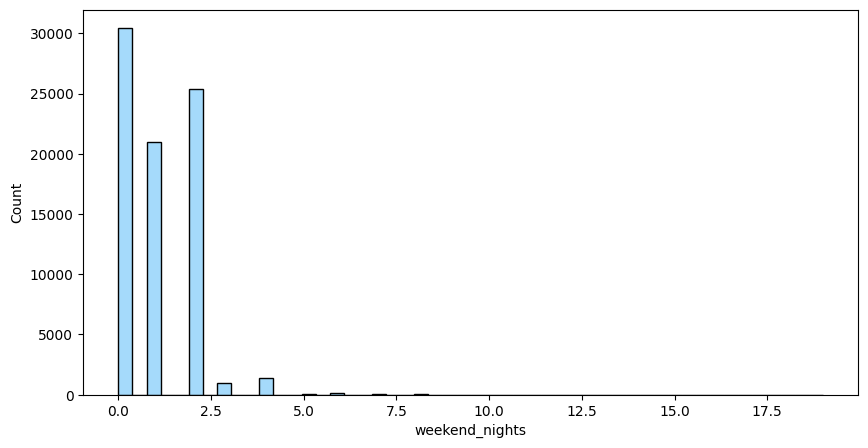

In [44]:
print(train_set.weekend_nights.value_counts())
fig, axs = plt.subplots(1,1, figsize = (10,5))
sns.histplot(train_set.weekend_nights, bins = 50, color = "lightskyblue");

Como en el caso anterior, se crea una nueva etiqueta para los valores por encima de 2. Las etiquetas resultantes son 0, 1, 2, 3 (3+).  
Se mantienen ambas variables.

In [45]:
#---------------------------- CAMBIO 8-----------------------------------------
# ELIMINACIÓN DE VALORES INCONSISTENTES COINCIDENTES EN LAS COLUMNAs 'week_nights' y 'weekend_nights'
# TRANSFORMACIÓN DE ETIQUETAS PARA UNIFICAR LOS VALORES POR ENCIMA DE 5 EN 'week_nights' Y POR ENCIMA DE 2 EN 'weekend_nights'

# Train
train_set = train_set.drop(train_set[(train_set["week_nights"] == 0)&(train_set["weekend_nights"] == 0)].index, axis = 0)
train_set.loc[train_set["week_nights"] > 5, "week_nights"] = 6
train_set.loc[train_set["weekend_nights"] > 2, "weekend_nights"] = 3

# Test
test_set = test_set.drop(test_set[(test_set["week_nights"] == 0)&(test_set["weekend_nights"] == 0)].index, axis = 0)
test_set.loc[test_set["week_nights"] > 5, "week_nights"] = 6
test_set.loc[test_set["weekend_nights"] > 2, "weekend_nights"] = 3

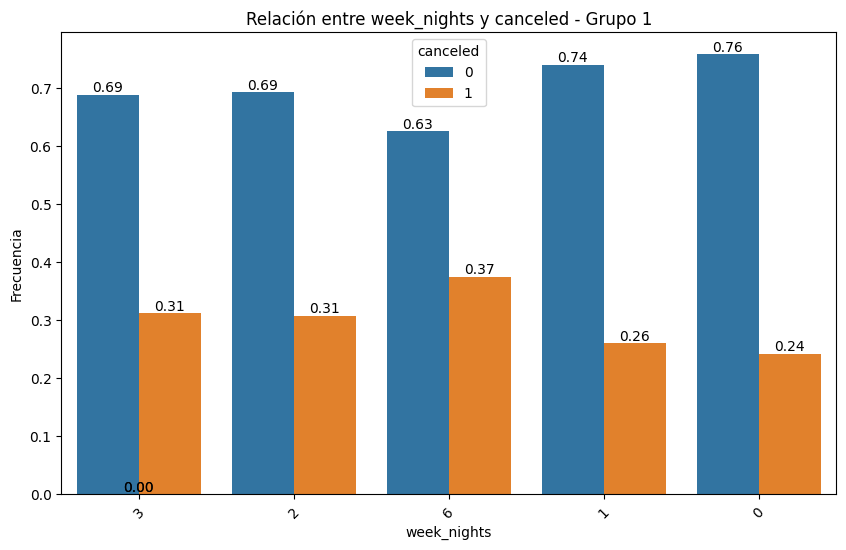

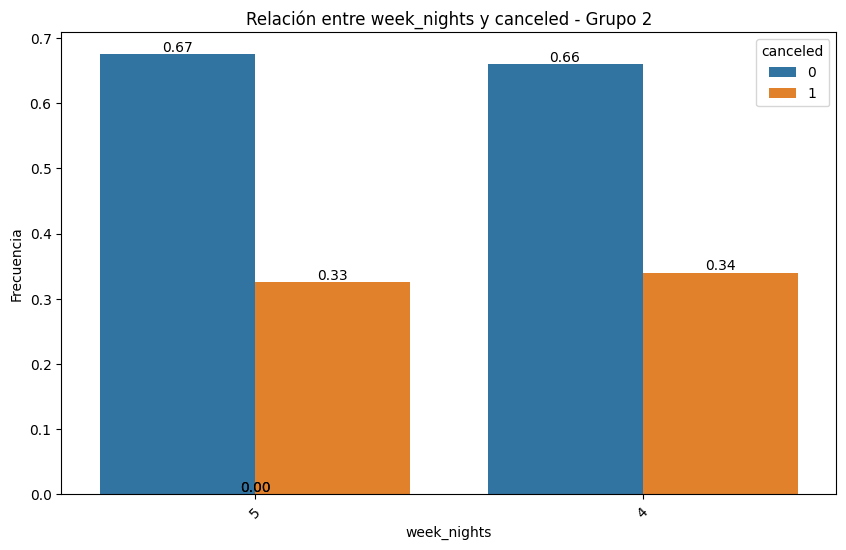

In [46]:
# Se observa la relación de nuevo
plot_categorical_relationship_fin(train_set, "week_nights","canceled", relative_freq = True, show_values = True)

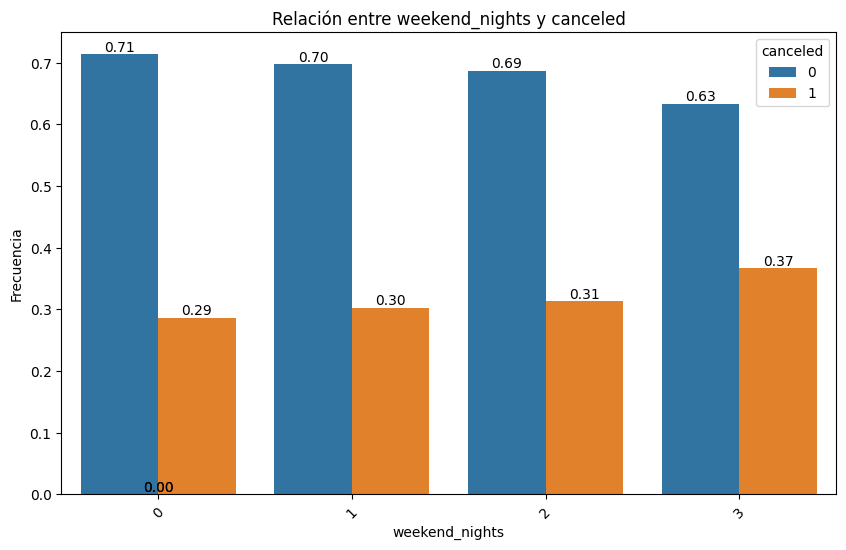

In [47]:
plot_categorical_relationship_fin(train_set, "weekend_nights","canceled", relative_freq = True, show_values = True)

##### MEAL_PLAN

meal_plan
BB    61722
HB     7336
SC     6805
RO     3265
FB      256
Name: count, dtype: int64


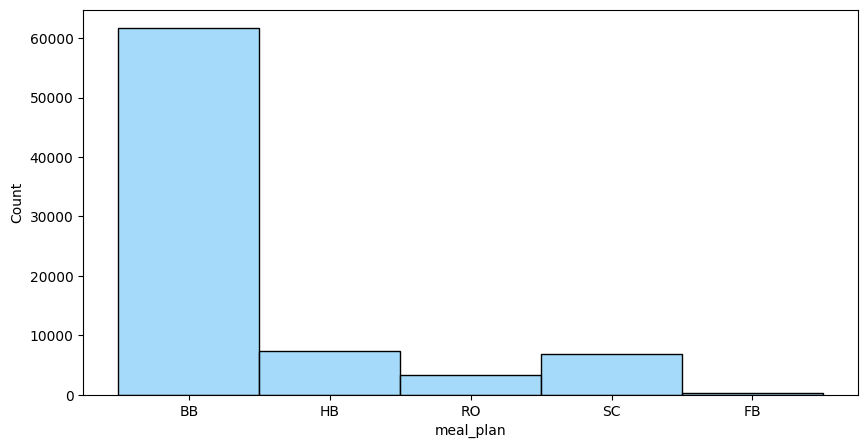

In [48]:
print(train_set.meal_plan.value_counts())
fig, axs = plt.subplots(1,1, figsize = (10,5))
sns.histplot(train_set.meal_plan, bins = 50, color = "lightskyblue");

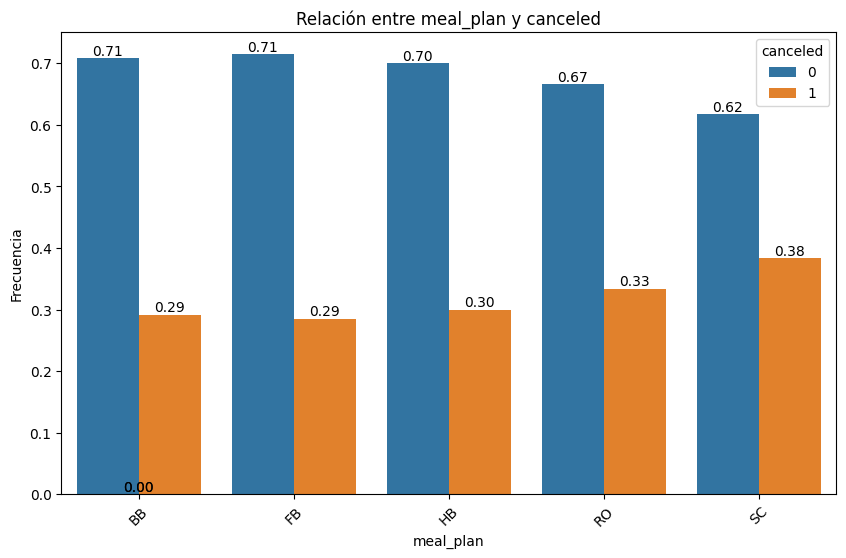

In [49]:
plot_categorical_relationship_fin(train_set, "meal_plan","canceled", relative_freq = True, show_values = True)

In [50]:
#---------------------------- CAMBIO 9-----------------------------------------
# TRANSFORMACIÓN DE 'meal_plan' A VARIABLE NUMÉRICA CON ORDINAL ENCODER

encoder = OrdinalEncoder(categories=[["SC","RO","BB","HB","FB"]])

# Train
train_set[["meal_plan"]] = encoder.fit_transform(train_set[["meal_plan"]])

# Test
test_set[["meal_plan"]] = encoder.fit_transform(test_set[["meal_plan"]])

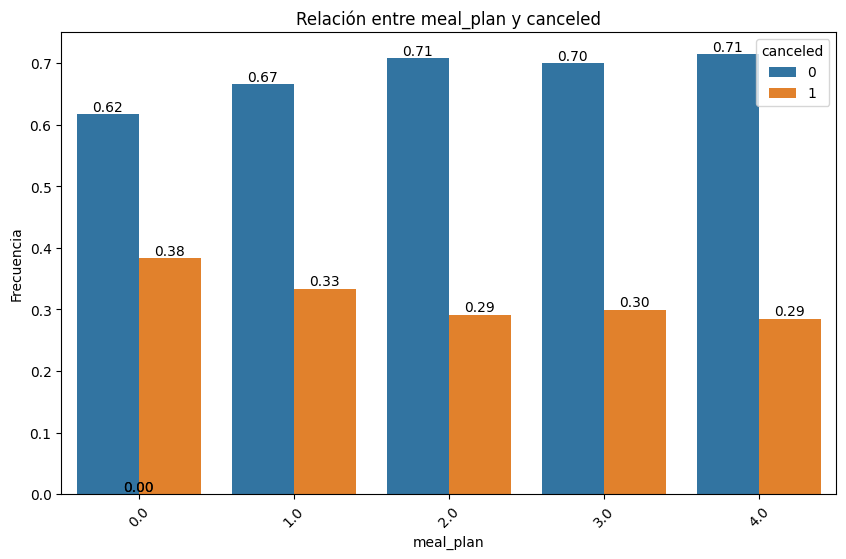

In [51]:
plot_categorical_relationship_fin(train_set, "meal_plan","canceled", relative_freq = True, show_values = True)

##### PARKING

parking
0    73562
1     5799
2       18
3        3
8        2
Name: count, dtype: int64


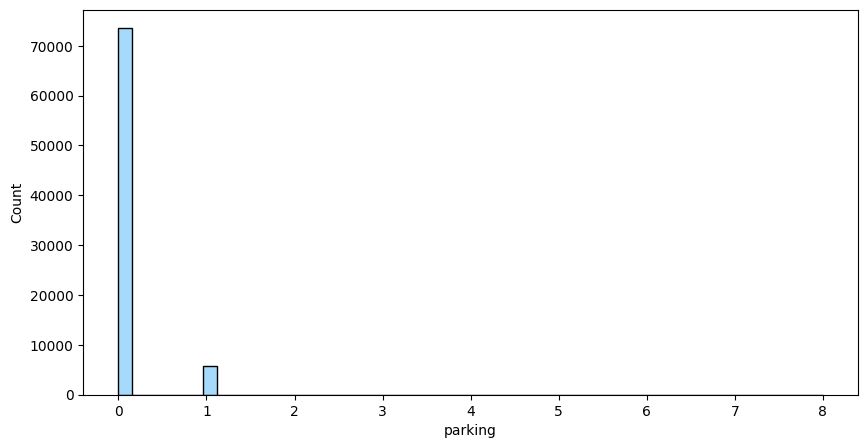

In [52]:
print(train_set.parking.value_counts())
fig, axs = plt.subplots(1,1, figsize = (10,5))
sns.histplot(train_set.parking, bins = 50, color = "lightskyblue");

Se transforma la variable a una categórica con los valores 0 (sin parking) y 1 (con parking).  
Se mantiene la variable, porque se observa un descenso en las cancelaciones en caso de reservar también el parking.

In [53]:
#---------------------------- CAMBIO 10-----------------------------------------
# TRANSFORMACIÓN DE 'parking' A VARIABLE BINARIA

# Train
train_set.loc[train_set["parking"] > 0, "parking"] = 1

# Test
test_set.loc[test_set["parking"] > 0, "parking"] = 1

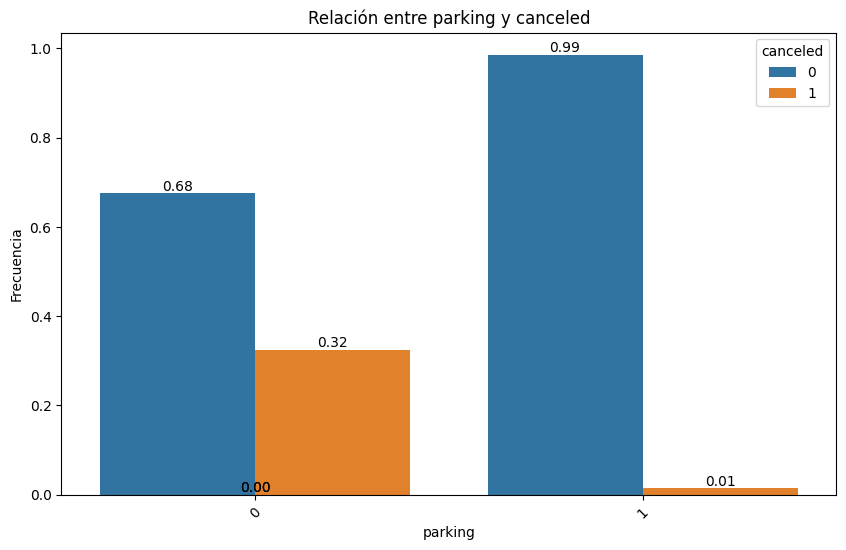

In [54]:
plot_categorical_relationship_fin(train_set, "parking","canceled", relative_freq = True, show_values = True)

##### SPECIAL_REQ

special_req
0    37071
1    28162
2    11667
3     2153
4      296
5       35
Name: count, dtype: int64


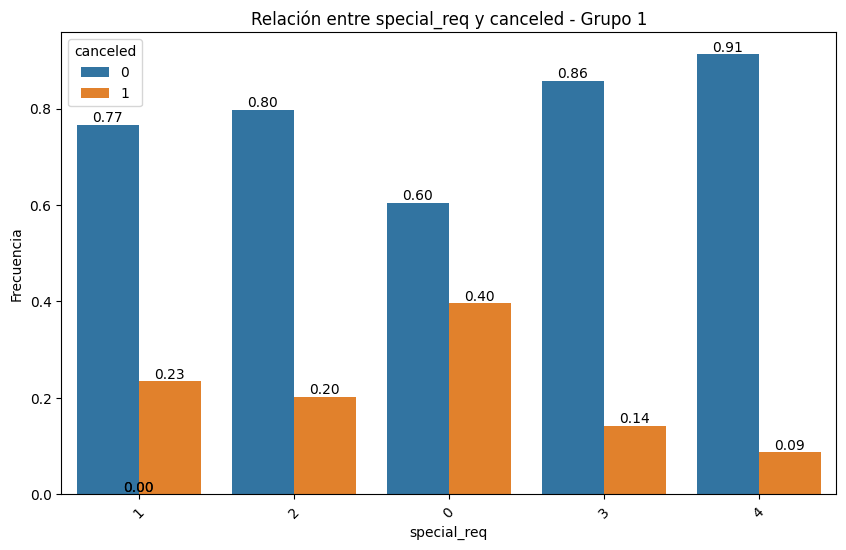

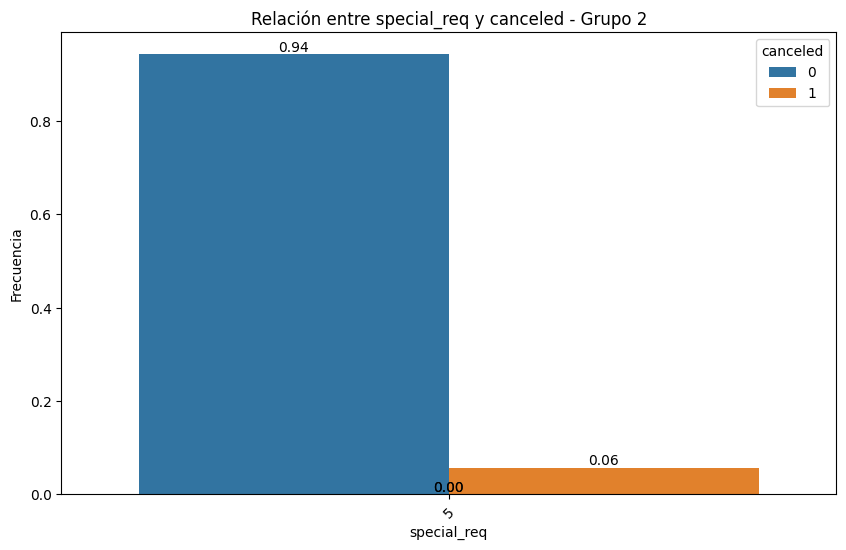

In [55]:
print(train_set.special_req.value_counts())
plot_categorical_relationship_fin(train_set, "special_req","canceled", relative_freq = True, show_values = True)

Se mantiene la variable sin cambios, al observarse un descenso en las cancelaciones conforme aumenta el número de peticiones especiales que atender en la reserva.

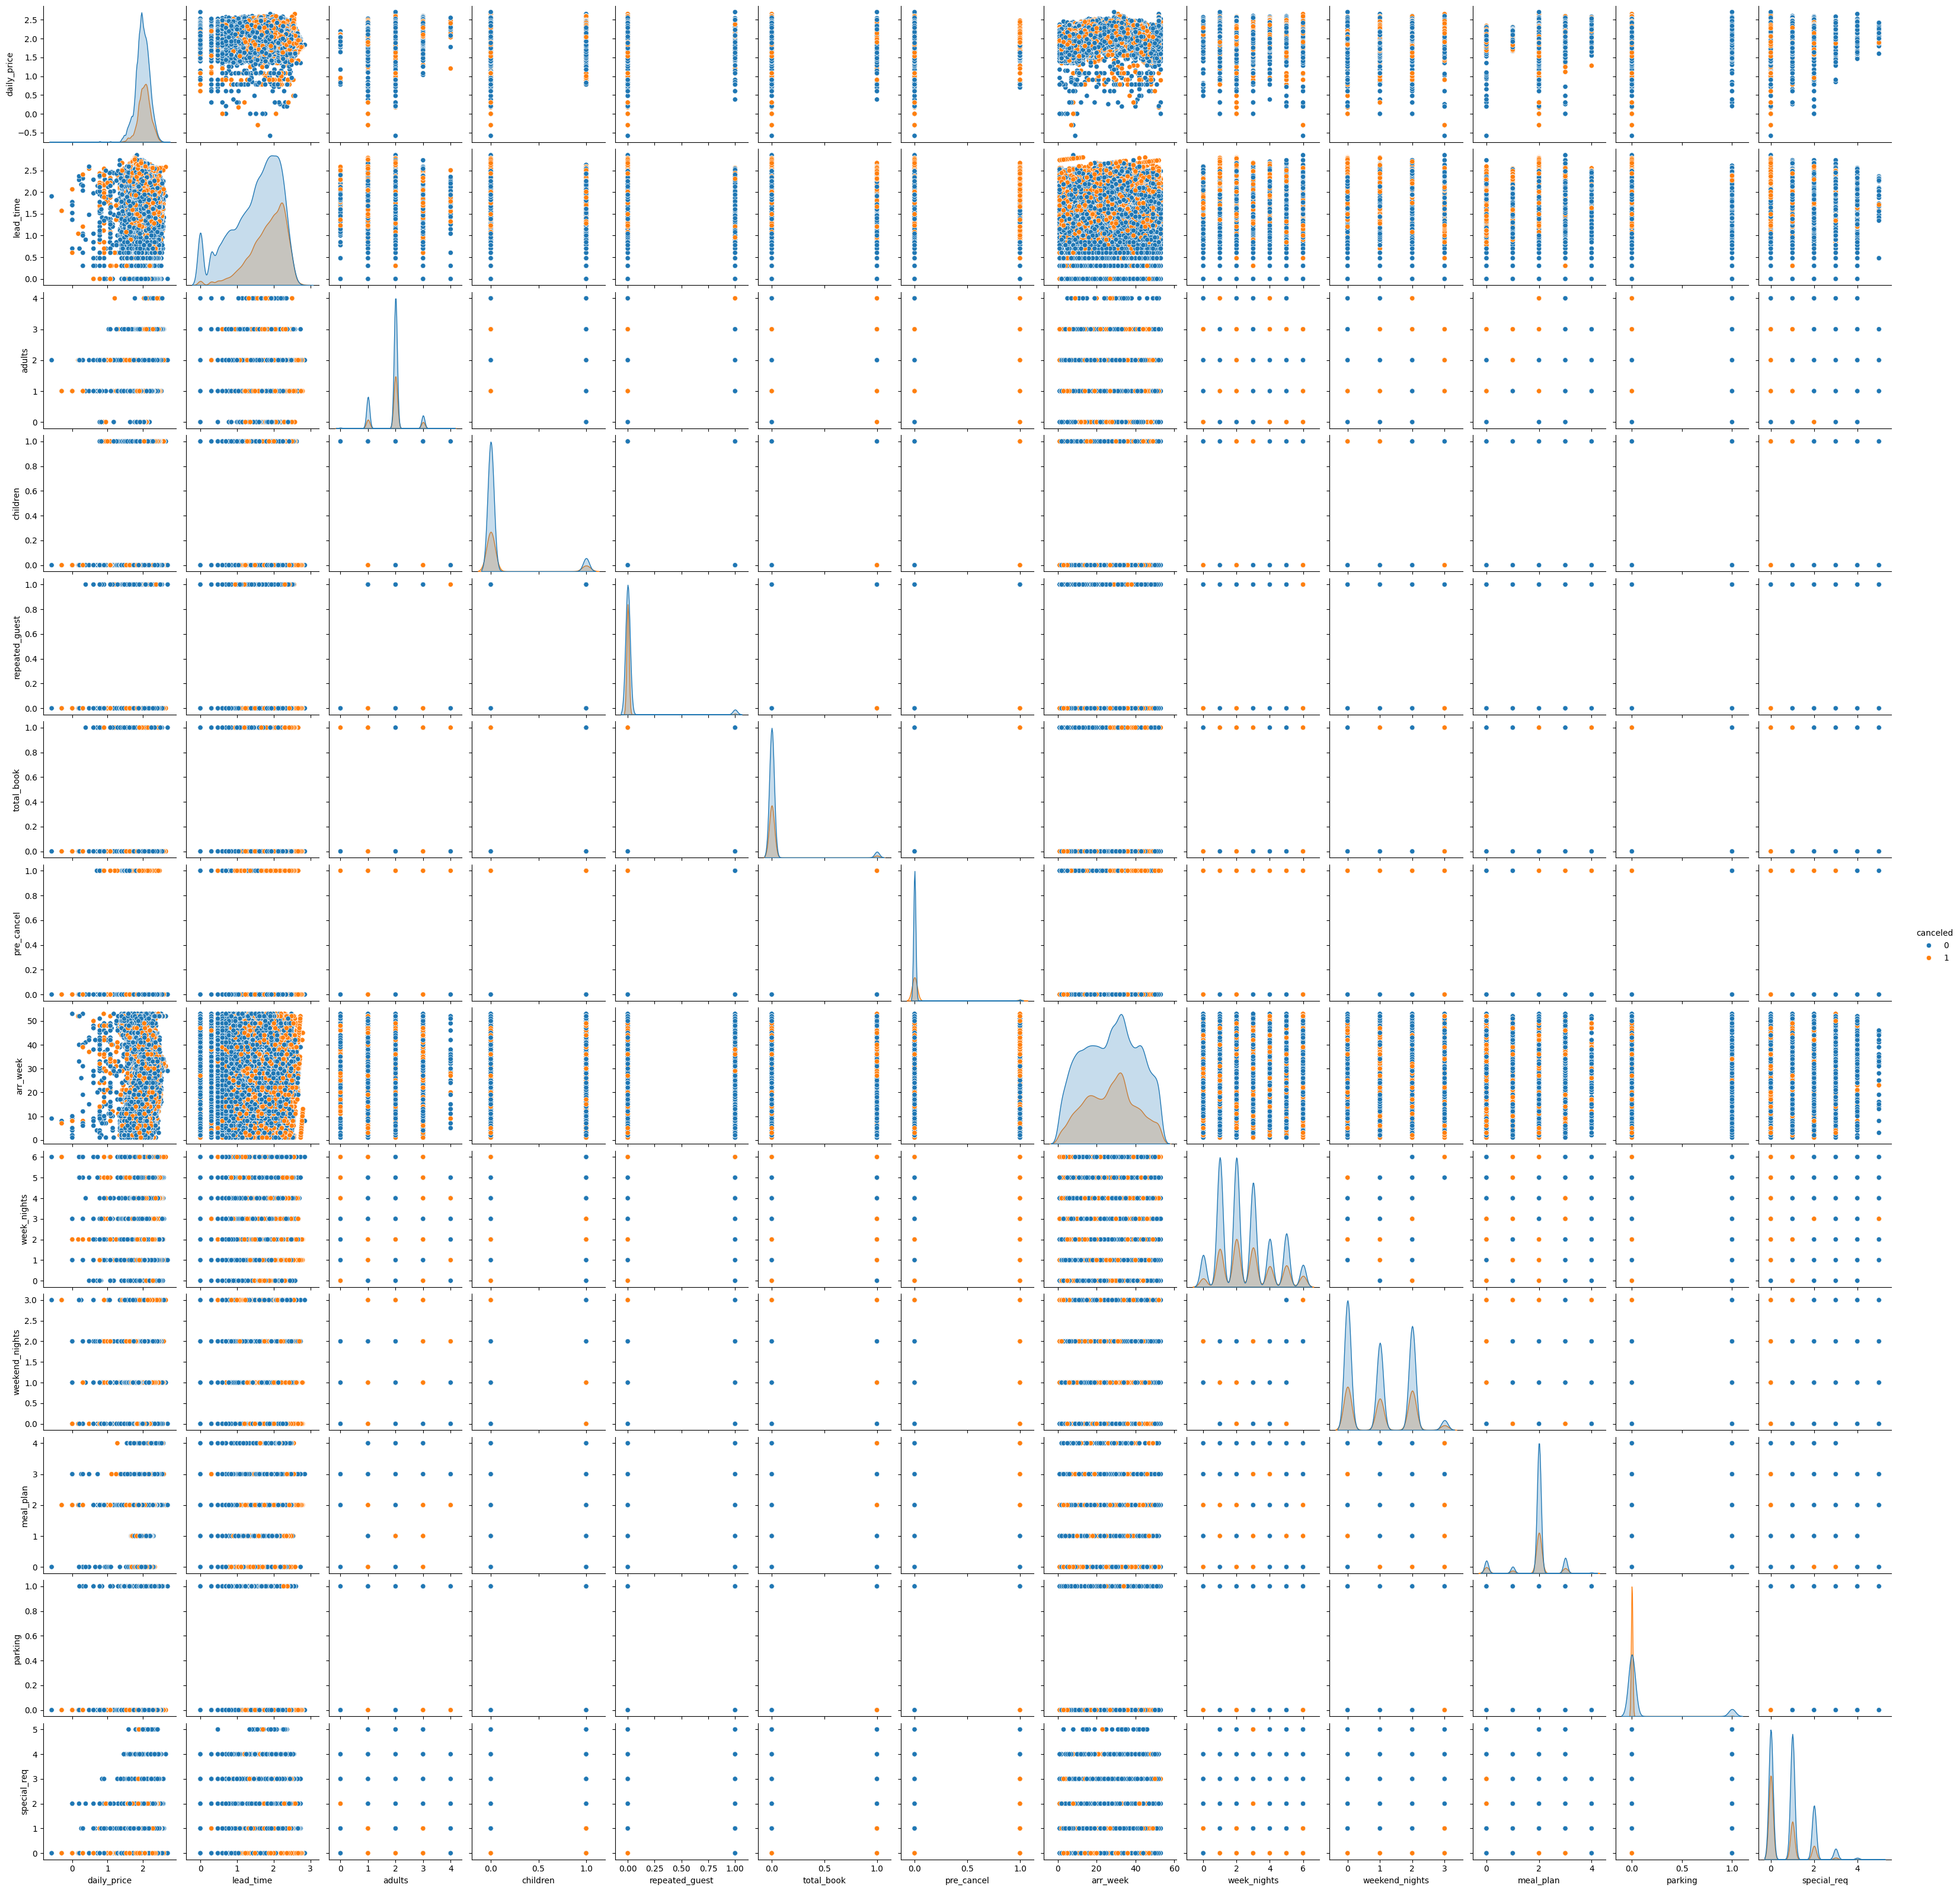

In [ ]:
# Se revisa visualmente la relación de variables dos a dos junto con la variable target
sns.pairplot(train_set, hue = "canceled");

In [56]:
# Se aplica una matriz de correlación para comprobar cómo se relacionan las variables con el 'target'
corr_matrix = train_set.corr(numeric_only = True)
corr_matrix["canceled"].sort_values(ascending = False)

canceled          1.000000
lead_time         0.237353
daily_price       0.120871
pre_cancel        0.093755
week_nights       0.065684
adults            0.062195
children          0.053855
weekend_nights    0.032582
arr_week         -0.007889
total_book       -0.016845
meal_plan        -0.049003
repeated_guest   -0.082326
parking          -0.176695
special_req      -0.182152
Name: canceled, dtype: float64

### TIPIFICACIÓN DE VARIABLES

In [57]:
# Se tipifican las variables y se incluyen en las listas correspondientes
df_tip = tipifica_variables(train_set, 11, 0.05)
df_tip

,nombre_variable,tipo_sugerido
0,daily_price,Numérica Continua
1,lead_time,Numérica Continua
2,adults,Categorica
3,children,Binaria
4,repeated_guest,Binaria
5,total_book,Binaria
6,pre_cancel,Binaria
7,arr_week,Numérica Continua
8,week_nights,Categorica
9,weekend_nights,Categorica


In [58]:
# Lista de variables categóricas
features_cat = df_tip.loc[(df_tip.tipo_sugerido == "Categorica")|(df_tip.tipo_sugerido == "Binaria")]["nombre_variable"].tolist()
features_cat.remove(target)
print(features_cat)

# Lista de variables numéricas
features_num = df_tip.loc[(df_tip.tipo_sugerido != "Categorica")&(df_tip.tipo_sugerido != "Binaria")]["nombre_variable"].tolist()
print(features_num)

['adults', 'children', 'repeated_guest', 'total_book', 'pre_cancel', 'week_nights', 'weekend_nights', 'meal_plan', 'parking', 'special_req']
['daily_price', 'lead_time', 'arr_week']


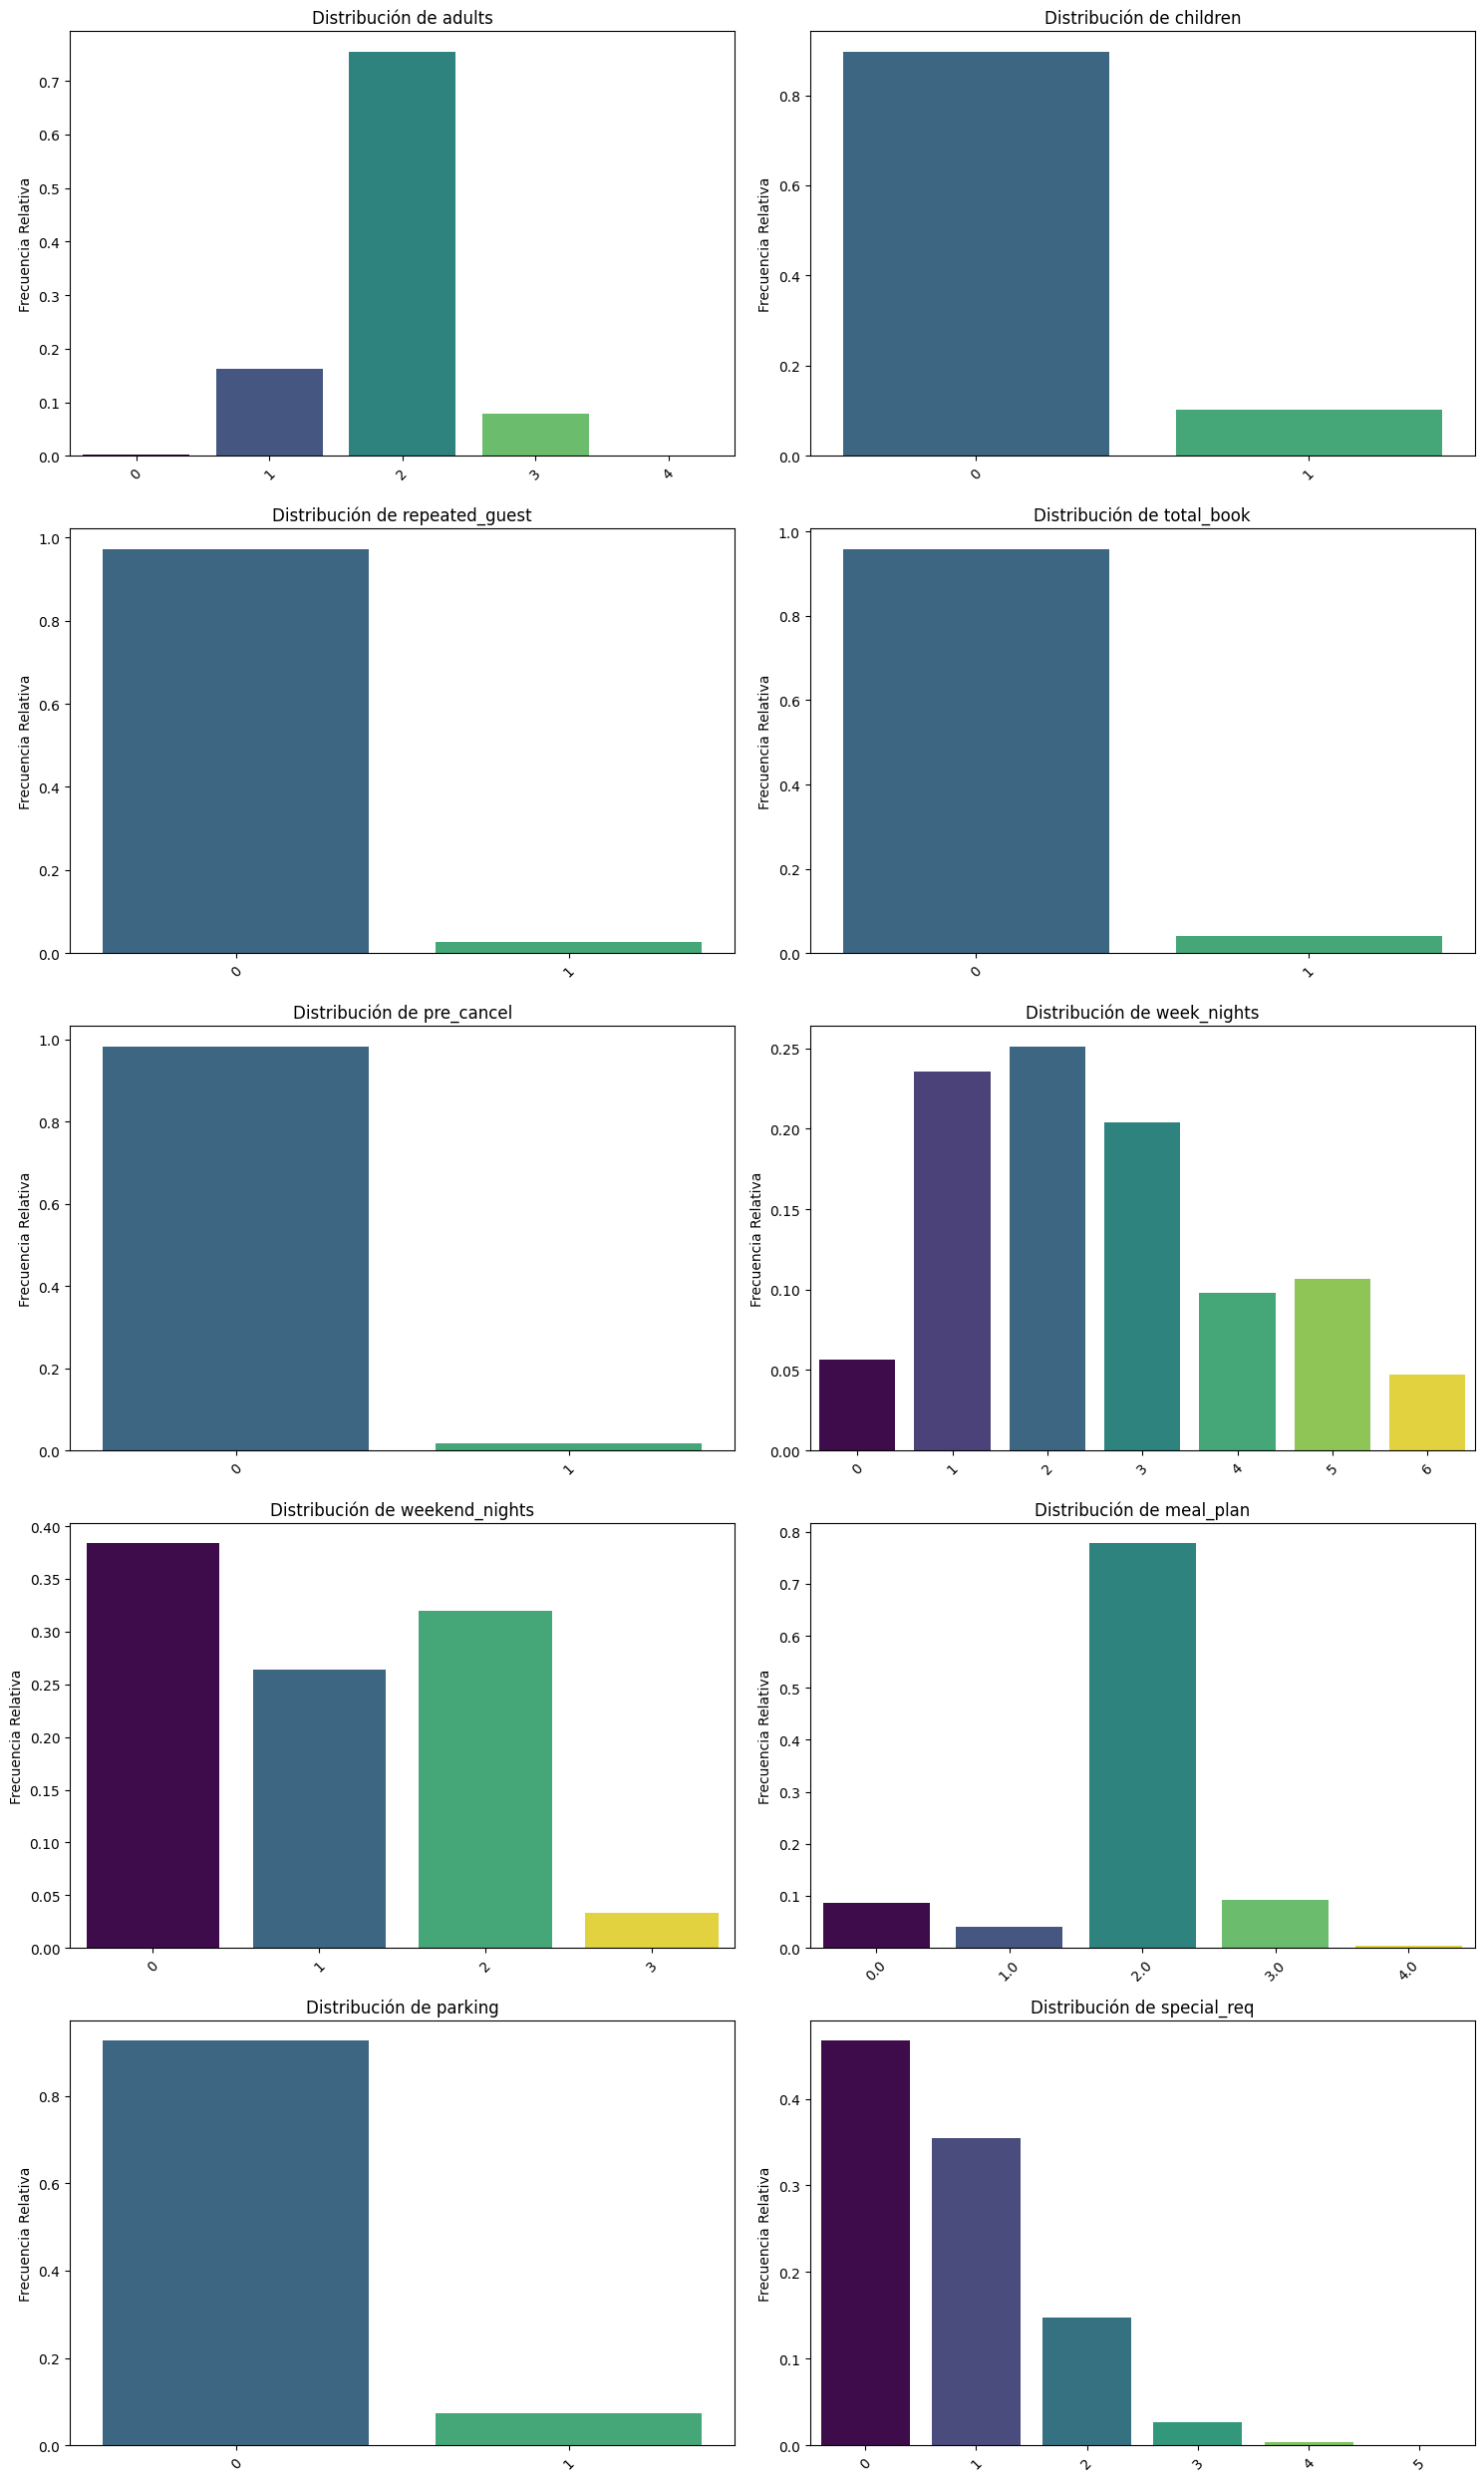

In [59]:
# Se revisan de nuevo las distribuciones generales de las variables categóricas
pinta_distribucion_categoricas(train_set, features_cat, relativa = True, mostrar_valores = False, giro = 45)

### RELACIÓN ESTADÍSTICA

In [60]:
# Se visualiza la relación estadística de las variables categóricas con la variable 'target'
for col in features_cat:
    tabla_contingencia = pd.crosstab(train_set["canceled"], train_set[col])
    chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
    print(f"{col}--{target}: chi2 = {chi2}, p_value = {p}")    

adults--canceled: chi2 = 371.17908932465434, p_value = 4.681361284063174e-79
children--canceled: chi2 = 229.86057603494248, p_value = 6.39364716238462e-52
repeated_guest--canceled: chi2 = 536.9301062709906, p_value = 8.7757634319971e-119
total_book--canceled: chi2 = 22.3410027539168, p_value = 2.2828004360746197e-06
pre_cancel--canceled: chi2 = 696.1725274367386, p_value = 2.0324340144831607e-153
week_nights--canceled: chi2 = 408.46574391965646, p_value = 4.229264477791831e-85
weekend_nights--canceled: chi2 = 100.57136676409175, p_value = 1.1712188752417987e-21
meal_plan--canceled: chi2 = 259.3367850648326, p_value = 6.3372843545796145e-55
parking--canceled: chi2 = 2476.971532388625, p_value = 0.0
special_req--canceled: chi2 = 3043.352990136845, p_value = 0.0


In [61]:
# Se visualiza la relación estadística de las variables numéricas con la variable 'target'
for col in features_num:
    grupo_a = train_set.loc[train_set.canceled == 0][col]
    grupo_b = train_set.loc[train_set.canceled == 1][col]
    u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)
    print(f"{col}--{target}: Estadístico U: {u_stat}, p_value = {p_valor}")

daily_price--canceled: Estadístico U: 557844877.0, p_value = 2.3664556994780012e-281
lead_time--canceled: Estadístico U: 471034688.5, p_value = 0.0
arr_week--canceled: Estadístico U: 672374267.5, p_value = 0.005181478677038875


### CONCLUSIONES